In [329]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
from scipy.stats import t
from itertools import combinations
from math import factorial
from scipy.stats import bootstrap

In [330]:
def stripper(x, length):
    dummy = []
    for i in x.strip().strip('[]').split():
        single = i.strip('\n')
        if single.isspace():
            continue
        if len(single) == 0:
            continue
        try:
            temp = float(single)
            dummy.append(temp)
        except:
            print(f"Warning: Couldn't convert {single} to float.")
    if len(dummy) != length:
        print(f"Warning: Only {len(dummy)} values were converted.")
    return dummy

In [331]:
# Calculate mean performance over all correlation thresholds for multitask SVM with RRR kernel kombination 

def calc_mean(x):
    """Calculate mean performance value over all correlation thresholds per model
        for ncv

    Parameters:
    -----------

    x: dictionary of floats

    Reuturns:
    ---------

    x: dictionary containing mean performance value per model

    """
    combis = ['RRP', 'RPP', 'RPR', 'RRR']
    columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
    for dataset in ['whole', 'selective']:
        for time in ['III14', "C-1"]:
                for col in columns:
                     #print(np.mean(x[dataset][f'{time}_ncv_mean'][col]))
                     x[dataset][f'{time}_ncv'].loc['mean_thresholds',col] = np.mean(x[dataset][f'{time}_ncv_mean'][col])
                     #print(x[dataset][f'{time}_ncv'][col])
    #print(x)
    return x

In [332]:
calc_mean(results)

{'whole': {'III14_test':                                                     RF  \
  0.1  [0.94375, 0.83541667, 0.94375, 1.0, 1.0, 0.795...   
  0.2  [0.94375, 0.83541667, 0.87083333, 1.0, 1.0, 0....   
  0.3  [0.90833333, 0.87083333, 0.83541667, 1.0, 0.90...   
  0.4  [0.90833333, 0.83541667, 0.87083333, 0.9027777...   
  0.5  [0.90833333, 0.87083333, 0.73125, 1.0, 1.0, 0....   
  0.6  [0.90833333, 0.87083333, 0.76666667, 0.9027777...   
  0.7  [0.90833333, 0.88392857, 0.76666667, 0.9027777...   
  0.8  [0.90833333, 0.8110119, 0.76666667, 1.0, 0.902...   
  0.9  [0.83541667, 0.8110119, 0.71934524, 0.86111111...   
  1.0  [0.79583333, 0.79583333, 0.83541667, 0.85, 0.4...   
  
                                                     RLR  \
  0.1  [1.0, 0.8110119, 0.94375, 0.90277778, 1.0, 0.9...   
  0.2  [1.0, 0.8110119, 0.94375, 1.0, 1.0, 0.94375, 0...   
  0.3  [1.0, 0.8110119, 0.94375, 1.0, 1.0, 0.94375, 1...   
  0.4  [0.90833333, 0.79583333, 0.94375, 1.0, 0.91666...   
  0.5  [1.0, 0

In [333]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes two-sided paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = 2 * t.sf(np.abs(t_stat), df)  # two-sided t-test
    return t_stat, p_val

In [334]:
# Dataholder for ROC_AUC performance measurment 
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['roc_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


In [335]:
results['whole']['III14_test_conf']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.8743750004, 0.9338309298488102]","[0.8796303207987697, 0.9466873087910923]","[0.8631671943708354, 0.9319166663999999]","[0.7884166671285636, 0.8761492489586454]","[0.7677877505317023, 0.8547499998000001]","[0.8843308998136002, 0.9366666663580996]","[0.8740833335317026, 0.9489999995751872]","[0.8627500006, 0.923666667]","[0.8692589234670038, 0.9346666665999999]","[0.8631182419046688, 0.9331666663999999]"
0.2,"[0.8627499998844177, 0.9272499999999999]","[0.868499999, 0.9412499994529188]","[0.8628679704288301, 0.9317499997227442]","[0.7443618653444221, 0.8470833335999999]","[0.8809999994585853, 0.9383333332]","[0.9081666661207186, 0.9554783676179895]","[0.884438435305658, 0.9485833328876696]","[0.8459452450082391, 0.9115833334]","[0.8781855803155689, 0.9494999998]","[0.8354977632078586, 0.9308333332000001]"
0.3,"[0.8400833334761001, 0.9065934824691867]","[0.8740463319723387, 0.9399166661999999]","[0.821666666677427, 0.8914166672]","[0.7702278985910246, 0.8529166667853668]","[0.807916667, 0.8764166668377996]","[0.9059166666082508, 0.9561666662449021]","[0.9090968079650098, 0.9563333331999999]","[0.8207149862709601, 0.8909274402942029]","[0.843083333341219, 0.9208333333616489]","[0.7712499994970443, 0.8737597697419803]"
0.4,"[0.8437224579541405, 0.9067034640865094]","[0.8877492527479195, 0.9464166662]","[0.8483333330548843, 0.9221666664]","[0.7693664066904059, 0.847416666150893]","[0.7457476647262266, 0.8400833334]","[0.8981666658, 0.9539166662317863]","[0.9150271183066575, 0.9568333328821113]","[0.8283472456977093, 0.8942500002665787]","[0.8478447378183819, 0.9164583331678275]","[0.8141666659999999, 0.8946666662]"
0.5,"[0.8246716551349285, 0.8914166663999998]","[0.878499999475384, 0.9447916663207]","[0.8257499999268856, 0.8955779508135029]","[0.7517030137630114, 0.8354349084636215]","[0.780020709727728, 0.8650833337208355]","[0.8999999994928168, 0.951583333]","[0.9250833329448256, 0.9651329044480136]","[0.7901250003217896, 0.8660833338072675]","[0.840991804422538, 0.915]","[0.8113333332, 0.89491666687587]"
0.6,"[0.8008749996, 0.871908899909371]","[0.8682267449431471, 0.9375833330000001]","[0.867, 0.9195833329567956]","[0.7615833334754972, 0.8366219255646307]","[0.7846666666716776, 0.8672006649647289]","[0.9206666665072656, 0.963999999864361]","[0.8940833332, 0.9554999998]","[0.7769583332, 0.8565360568651033]","[0.8620764264301259, 0.9335416668000001]","[0.8177267572506838, 0.8999166664252778]"
0.7,"[0.8067500003345582, 0.8755416665351932]","[0.8985833334, 0.9544166666000001]","[0.8210833334000001, 0.8927499999326516]","[0.7953333336, 0.8690000000572949]","[0.841746121987436, 0.912499999737623]","[0.9155339821918079, 0.9607499996]","[0.9156666662, 0.9589166664]","[0.7748834092561713, 0.8629041922961125]","[0.8510833328466284, 0.9200416664]","[0.823691573935765, 0.888333333658592]"
0.8,"[0.7534357563585432, 0.8357499999999999]","[0.8769243459124673, 0.9387083333999999]","[0.7072500000010115, 0.78953369787897]","[0.7989166668045375, 0.8647499997207474]","[0.8036666663292218, 0.8738333327999999]","[0.922583333247347, 0.9653333330000001]","[0.8900293107147819, 0.9516666662]","[0.733952418068885, 0.8149166660081139]","[0.8416249997999999, 0.9027916664]","[0.4569176224643486, 0.5969166666]"
0.9,"[0.7304999998682498, 0.8144999999114487]","[0.8693333334000001, 0.9361666665999999]","[0.6961666664510473, 0.7880833333999999]","[0.7993333334, 0.8613666509225629]","[0.8503333331999999, 0.9091666663999999]","[0.901416665984851, 0.9540833327999999]","[0.9086666666, 0.9583333329999999]","[0.7383139522151084, 0.82225]","[0.7865088127154031, 0.8758333333709125]","[0.5415252325650698, 0.662738385098028]"
1.0,"[0.7242368043737649, 0.8055833334712882]","[0.866083332848601, 0.9359999998]","[0.7035833334, 0.7911031084991872]","[0.8042273399981824, 0.8794166662]","[0.8569407005125835, 0.9152572818702387]","[0.9143333333999999, 0.9573333330113525]","[0.8727499995085765, 0.939713

In [336]:
results['whole']['III14_test']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.875, 0.937...","[1.0, 0.75, 0.9375, 0.93333333, 0.93333333, 0....","[0.9375, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.875...","[1.0, 0.6875, 0.9375, 0.93333333, 0.8, 0.875, ...","[1.0, 0.5625, 0.875, 0.93333333, 0.93333333, 0...","[0.9375, 0.6875, 0.9375, 1.0, 1.0, 0.9375, 0.8...","[0.9375, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, ...","[1.0, 0.75, 0.9375, 0.93333333, 1.0, 0.6875, 0...","[0.875, 0.75, 0.9375, 1.0, 0.93333333, 0.875, ...","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0..."
0.2,"[0.9375, 0.875, 0.8125, 1.0, 1.0, 0.9375, 0.93...","[1.0, 0.75, 0.9375, 1.0, 0.93333333, 0.9375, 1...","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.8125, 0.5, 0.75, 0.93333333, 1.0, 0.875, 0....","[1.0, 0.875, 0.9375, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[0.96875, 0.6875, 0.84375, 0.93333333, 1.0, 0....","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.875, 0.9375, 1...","[0.875, 0.6875, 0.9375, 1.0, 1.0, 0.9375, 0.87..."
0.3,"[0.9375, 0.875, 0.8125, 1.0, 0.93333333, 1.0, ...","[1.0, 0.75, 0.9375, 1.0, 0.93333333, 0.9375, 1...","[0.9375, 0.6875, 0.875, 1.0, 1.0, 0.8125, 0.87...","[0.875, 0.6875, 0.75, 0.86666667, 0.93333333, ...","[0.5, 0.8125, 0.9375, 0.93333333, 0.86666667, ...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1.0...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1....","[1.0, 0.875, 0.75, 0.93333333, 0.8, 0.9375, 0....","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.75, 0.6875, 0.8125, 0.93333333, 1.0, 0.8125..."
0.4,"[0.875, 0.8125, 0.875, 0.93333333, 1.0, 1.0, 0...","[0.9375, 0.75, 0.9375, 1.0, 0.93333333, 0.9375...","[0.8125, 0.75, 1.0, 0.93333333, 1.0, 0.8125, 0...","[0.75, 0.6875, 0.875, 0.93333333, 0.86666667, ...","[0.5, 0.875, 0.8125, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.93...","[0.875, 0.84375, 0.9375, 0.93333333, 0.8, 0.87...","[0.875, 0.6875, 0.9375, 1.0, 0.93333333, 0.812...","[0.875, 0.625, 0.9375, 0.93333333, 0.53333333,..."
0.5,"[0.8125, 0.875, 0.75, 1.0, 1.0, 0.9375, 0.8125...","[1.0, 0.8125, 0.9375, 1.0, 0.93333333, 0.9375,...","[1.0, 0.6875, 0.8125, 1.0, 0.86666667, 0.875, ...","[0.5625, 0.75, 0.8125, 0.93333333, 0.93333333,...","[0.75, 0.8125, 0.625, 0.93333333, 0.86666667, ...","[1.0, 0.75, 0.875, 1.0, 1.0, 0.875, 1.0, 1.0, ...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1....","[0.9375, 0.75, 0.875, 0.93333333, 0.8, 0.875, ...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.875, 0.937...","[0.875, 0.625, 0.75, 0.93333333, 1.0, 0.875, 0..."
0.6,"[0.875, 0.875, 0.875, 0.93333333, 1.0, 0.9375,...","[0.875, 0.8125, 0.9375, 0.86666667, 1.0, 0.937...","[1.0, 0.75, 0.875, 0.8, 1.0, 0.9375, 0.8125, 1...","[0.625, 0.75, 0.875, 0.93333333, 0.86666667, 0...","[0.75, 0.875, 0.875, 0.86666667, 0.86666667, 0...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[0.9375, 0.75, 0.8125, 0.86666667, 1.0, 1.0, 0...","[1.0, 0.75, 1.0, 0.86666667, 1.0, 0.9375, 0.87...","[1.0, 0.625, 0.9375, 0.86666667, 1.0, 0.8125, ..."
0.7,"[0.875, 0.84375, 0.8125, 0.93333333, 1.0, 1.0,...","[0.9375, 0.8125, 0.9375, 0.86666667, 1.0, 0.93...","[0.8125, 0.875, 0.75, 0.8, 0.86666667, 0.875, ...","[0.75, 0.6875, 0.8125, 1.0, 1.0, 0.6875, 0.875...","[0.75, 0.9375, 0.875, 0.93333333, 1.0, 0.625, ...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.875, ...","[0.875, 0.6875, 0.875, 0.93333333, 1.0, 1.0, 0...","[0.9375, 0.875, 0.9375, 0.93333333, 1.0, 0.937...","[0.9375, 0.8125, 0.75, 0.93333333, 0.86666667,..."
0.8,"[0.84375, 0.75, 0.8125, 1.0, 0.93333333, 1.0, ...","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 0.9...","[0.75, 0.75, 0.75, 0.93333333, 0.86666667, 0.7...","[0.5625, 0.75, 0.8125, 1.0, 1.0, 0.75, 0.75, 1...","[0.625, 0.875, 0.6875, 0.86666667, 0.93333333,.

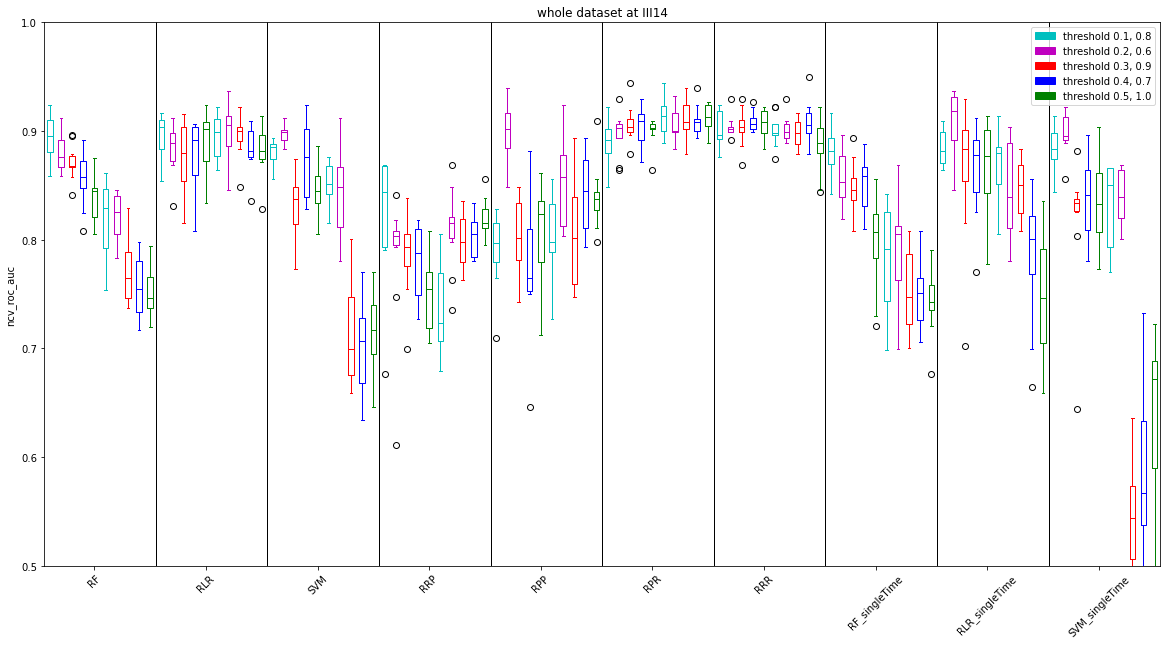

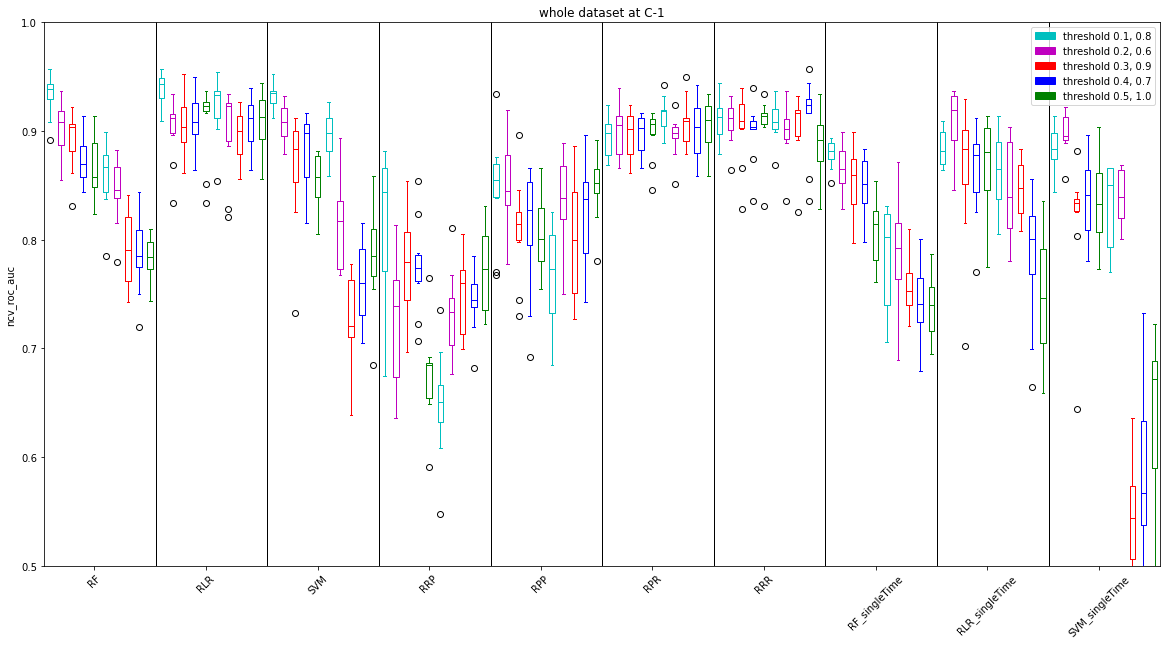

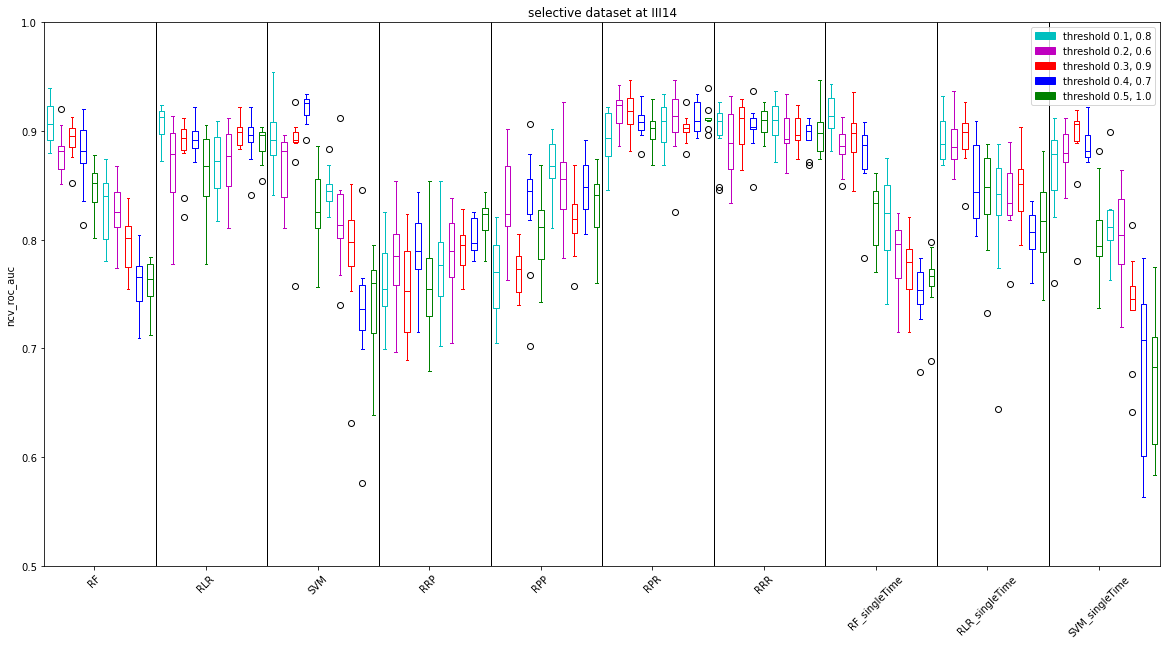

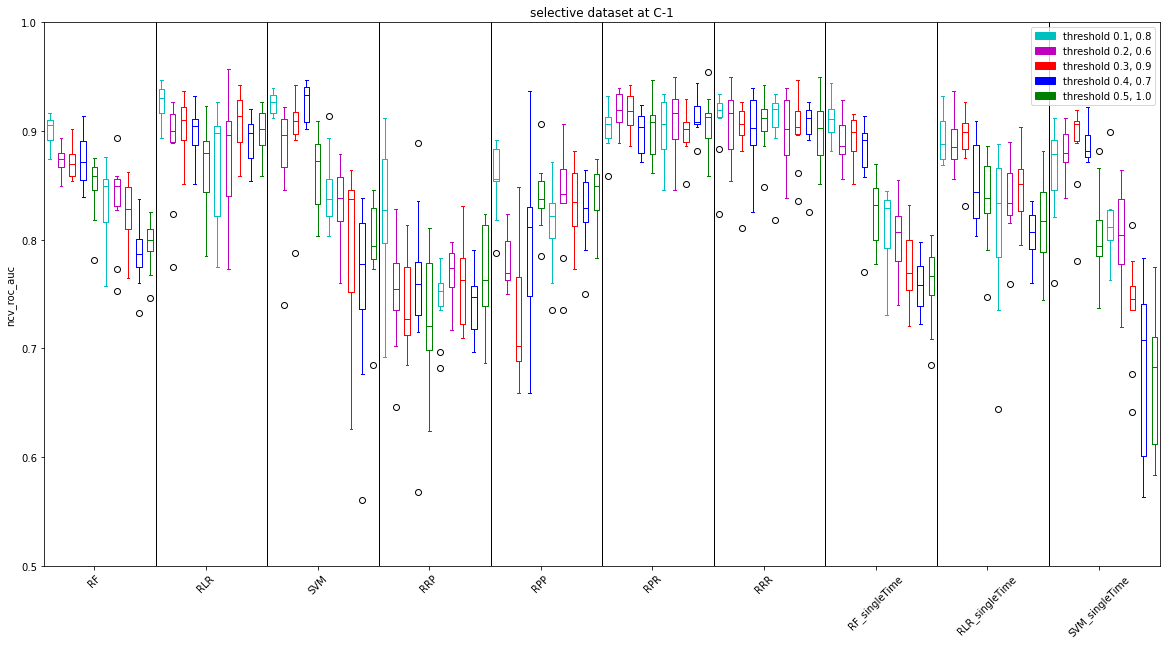

In [337]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0.5, 1))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("ncv_roc_auc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

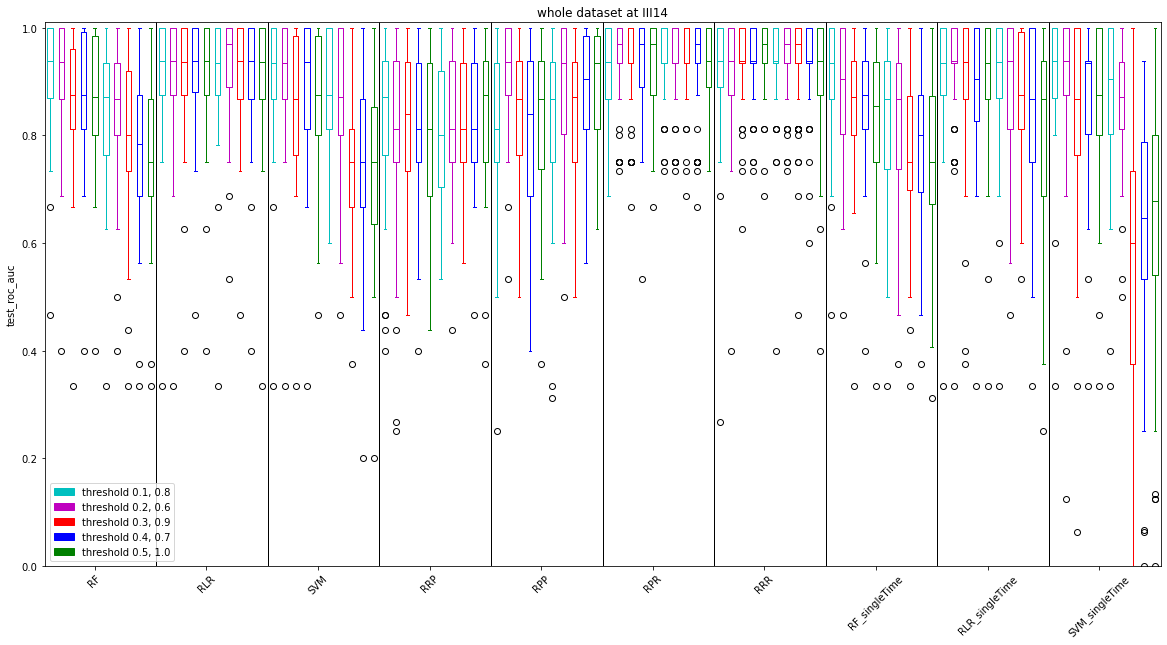

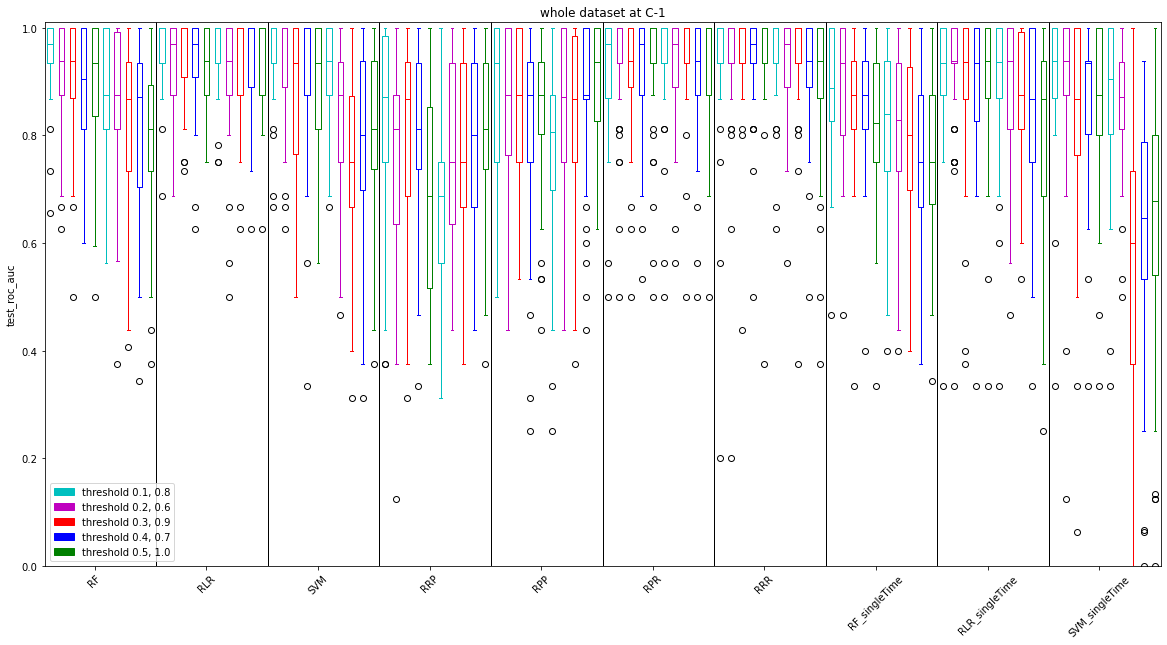

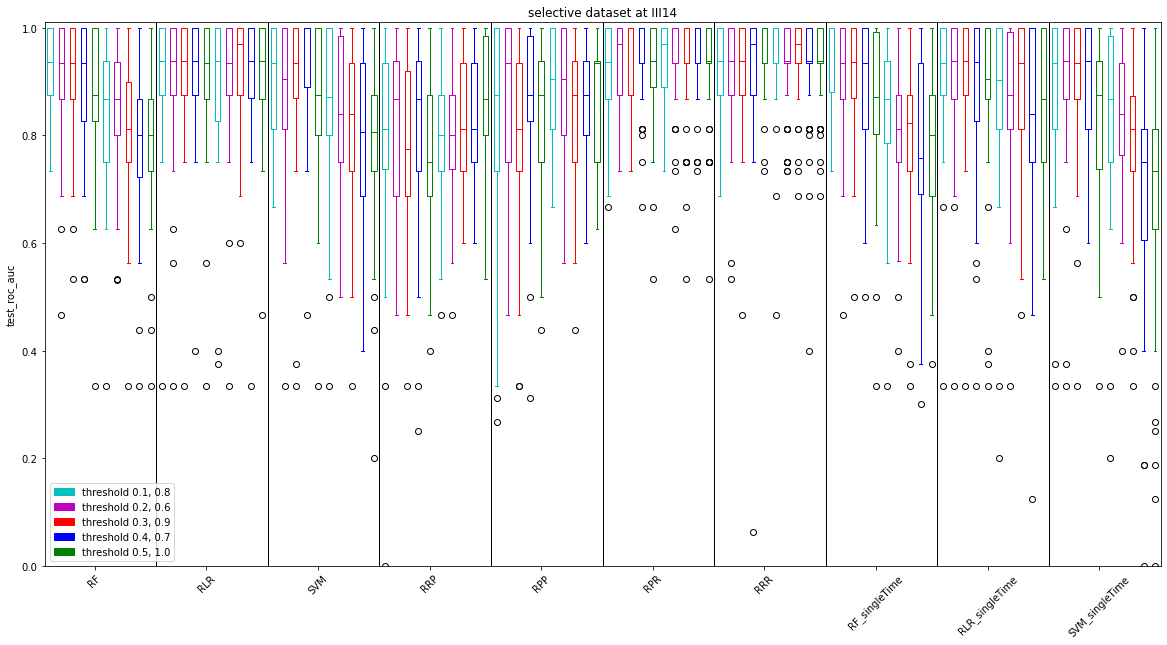

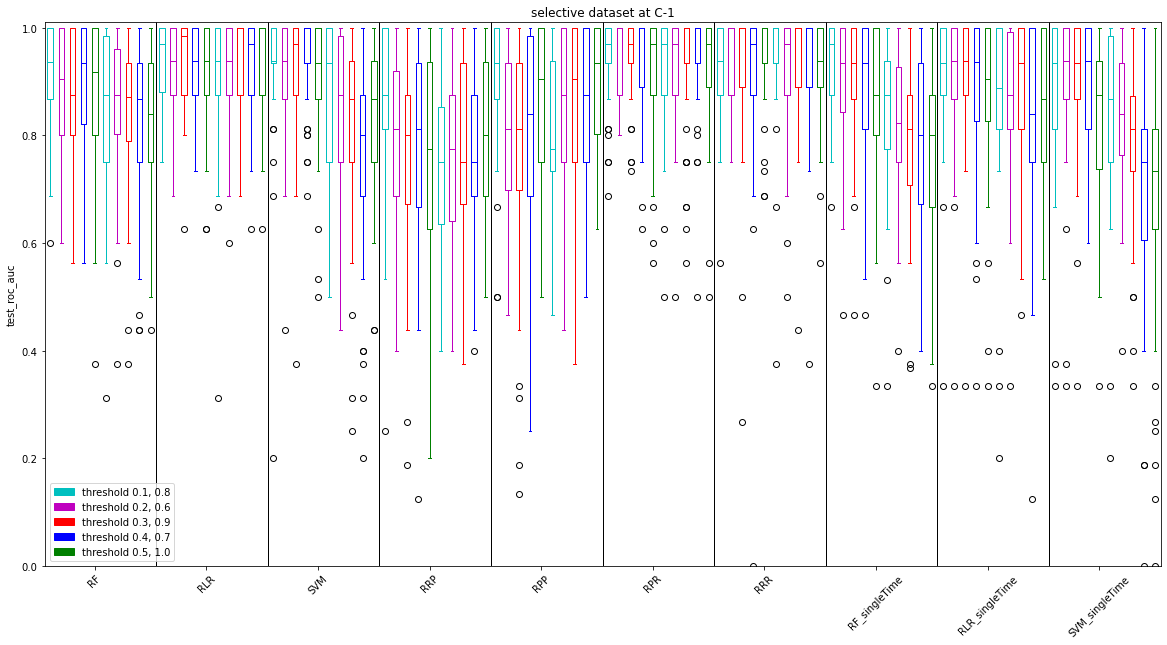

In [338]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_test'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1.01, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0, 1.01))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("test_roc_auc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [339]:
# Dataholder for precision_recall_ROC_AUC performance measurment 
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_roc_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_roc_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_roc_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_roc_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


In [340]:
results['whole']['III14_test']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.75, 0.937...","[1.0, 0.75, 0.9375, 0.93333333, 1.0, 0.9375, 0...","[0.9375, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.875...","[1.0, 0.6875, 0.9375, 0.93333333, 0.93333333, ...","[1.0, 0.5625, 0.875, 0.93333333, 1.0, 0.4375, ...","[0.9375, 0.6875, 0.9375, 0.86666667, 1.0, 0.93...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0,...","[0.9375, 0.75, 0.9375, 0.93333333, 0.86666667,...","[0.875, 0.75, 0.9375, 1.0, 0.93333333, 0.875, ...","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0..."
0.2,"[0.9375, 0.8125, 0.875, 1.0, 1.0, 0.9375, 0.87...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.5625, 0.5625, 0.75, 0.93333333, 0.93333333,...","[1.0, 0.875, 0.9375, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 0.9375, ...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[1.0, 0.6875, 0.875, 0.93333333, 1.0, 0.875, 1...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.875, 1.0, 1.0,...","[0.875, 0.6875, 0.9375, 1.0, 1.0, 0.9375, 1.0,..."
0.3,"[0.875, 0.875, 0.8125, 1.0, 0.93333333, 1.0, 0...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1.0...","[0.75, 0.8125, 0.875, 1.0, 1.0, 0.8125, 0.875,...","[0.5625, 0.6875, 0.75, 0.86666667, 0.93333333,...","[0.5, 0.75, 0.75, 0.93333333, 0.86666667, 0.81...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1.0...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1....","[0.9375, 0.875, 0.8125, 0.93333333, 0.93333333...","[0.9375, 0.75, 0.9375, 0.93333333, 1.0, 0.875,...","[0.75, 0.6875, 0.8125, 0.93333333, 1.0, 0.8125..."
0.4,"[0.875, 0.8125, 0.875, 0.93333333, 1.0, 0.9062...","[0.875, 0.75, 0.9375, 1.0, 0.93333333, 0.875, ...","[0.8125, 0.6875, 1.0, 1.0, 1.0, 0.875, 0.75, 1...","[0.75, 0.5625, 0.875, 0.93333333, 0.86666667, ...","[0.5, 0.875, 0.8125, 0.93333333, 1.0, 0.875, 0...","[1.0, 0.75, 0.9375, 1.0, 0.93333333, 0.9375, 0...","[0.9375, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.93...","[0.875, 0.84375, 0.9375, 0.93333333, 0.6666666...","[0.875, 0.6875, 0.9375, 1.0, 0.93333333, 0.812...","[0.875, 0.625, 0.9375, 0.93333333, 0.53333333,..."
0.5,"[0.875, 0.875, 0.75, 1.0, 1.0, 0.9375, 0.8125,...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[1.0, 0.6875, 0.75, 1.0, 0.86666667, 0.875, 0....","[0.875, 0.8125, 0.625, 0.93333333, 0.93333333,...","[0.8125, 0.8125, 0.625, 0.93333333, 0.86666667...","[1.0, 0.75, 0.875, 1.0, 1.0, 0.9375, 1.0, 1.0,...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[0.875, 0.75, 0.8125, 0.93333333, 1.0, 0.875, ...","[1.0, 0.875, 0.9375, 0.93333333, 1.0, 0.875, 1...","[0.875, 0.625, 0.75, 0.93333333, 1.0, 0.875, 0..."
0.6,"[0.875, 0.875, 0.8125, 0.93333333, 1.0, 1.0, 0...","[0.875, 0.8125, 0.9375, 0.86666667, 1.0, 0.937...","[1.0, 0.6875, 0.875, 0.8, 1.0, 0.9375, 1.0, 1....","[0.5625, 0.5625, 0.75, 0.86666667, 0.86666667,...","[0.6875, 0.625, 0.875, 0.86666667, 0.86666667,...","[1.0, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1...","[1.0, 0.75, 0.9375, 1.0, 1.0, 0.9375, 1.0, 1.0...","[0.875, 0.8125, 0.8125, 0.93333333, 0.93333333...","[1.0, 0.75, 1.0, 0.86666667, 1.0, 0.9375, 1.0,...","[1.0, 0.625, 0.9375, 0.86666667, 0.7, 0.8125, ..."
0.7,"[0.875, 0.8125, 0.8125, 0.93333333, 1.0, 0.937...","[0.9375, 0.8125, 0.9375, 0.86666667, 1.0, 0.93...","[0.8125, 0.8125, 0.75, 0.8, 0.86666667, 0.875,...","[0.75, 0.6875, 0.6875, 1.0, 0.86666667, 0.6875...","[0.75, 0.9375, 0.875, 0.93333333, 1.0, 0.625, ...","[0.875, 0.75, 0.9375, 1.0, 0.93333333, 0.9375,...","[1.0, 0.875, 0.9375, 1.0, 1.0, 0.9375, 0.875, ...","[1.0, 0.8125, 0.875, 0.93333333, 1.0, 0.9375, ...","[1.0, 0.875, 0.75, 0.93333333, 1.0, 0.9375, 1....","[0.9375, 0.75, 0.75, 0.93333333, 0.5, 0.8125, ..."
0.8,"[0.875, 0.75, 0.8125, 1.0, 0.93333333, 1.0, 0....","[0.9375, 0.8125, 0.9375, 1.0, 1.0, 0.9375, 0.9...","[0.6875, 0.6875, 0.75, 0.93333333, 0.86666667,...","[0.5625, 0.6875, 0.8125, 1.0, 1.0, 0.8125, 0.6...","[0.625, 0.625, 0.6875, 0.86666667, 0.93333333,.

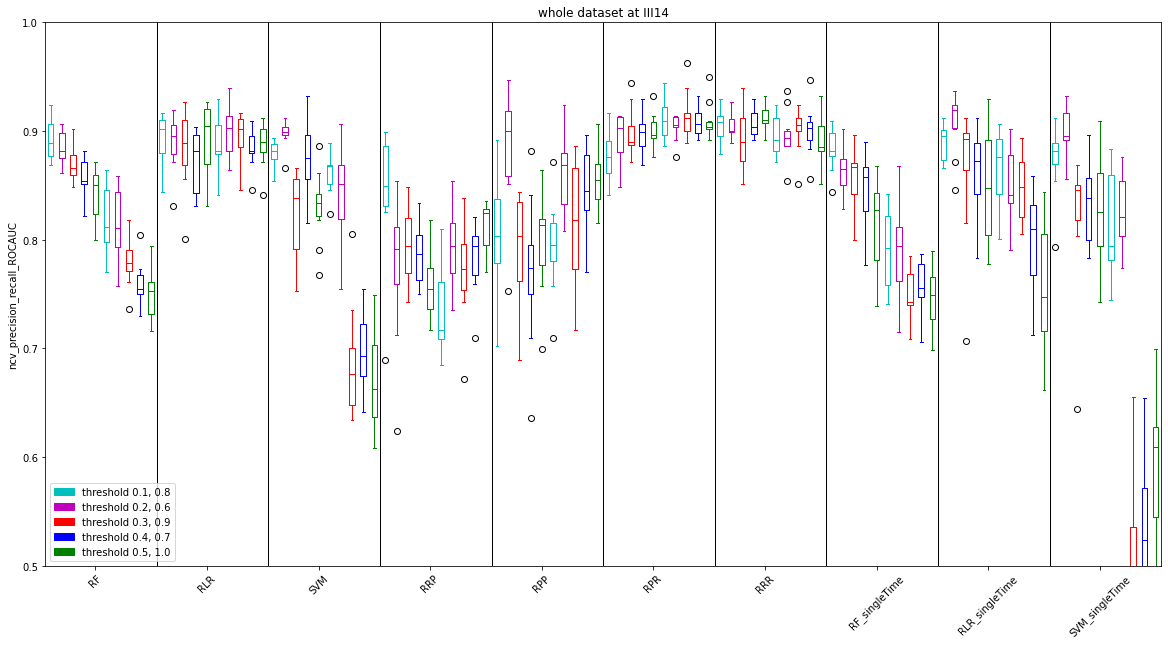

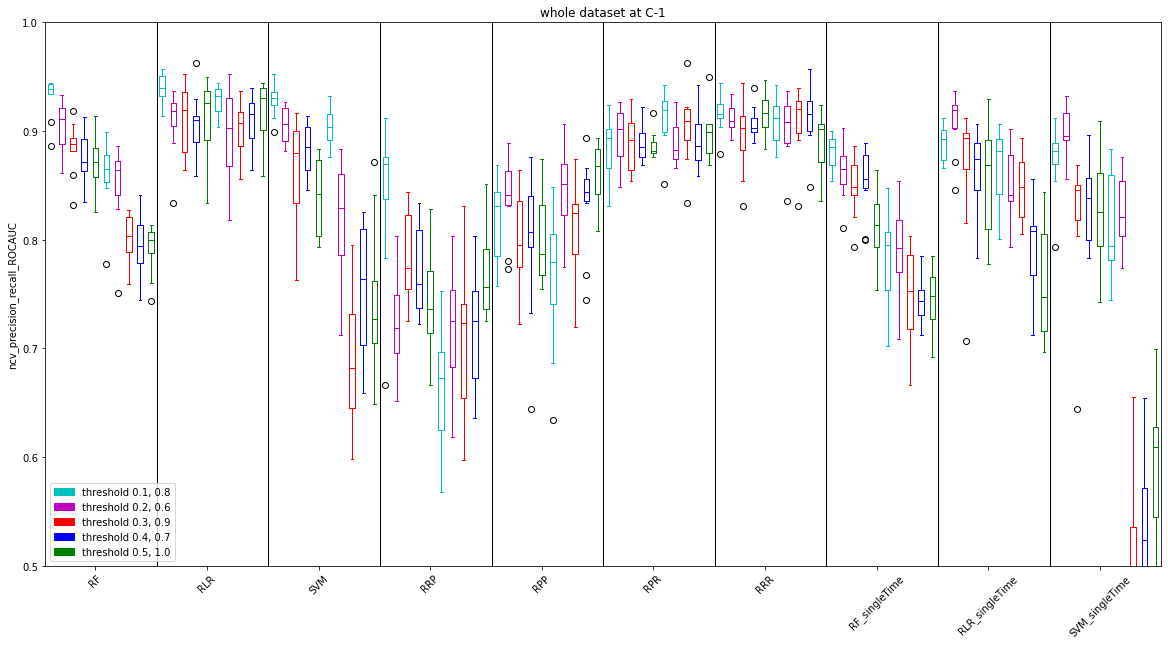

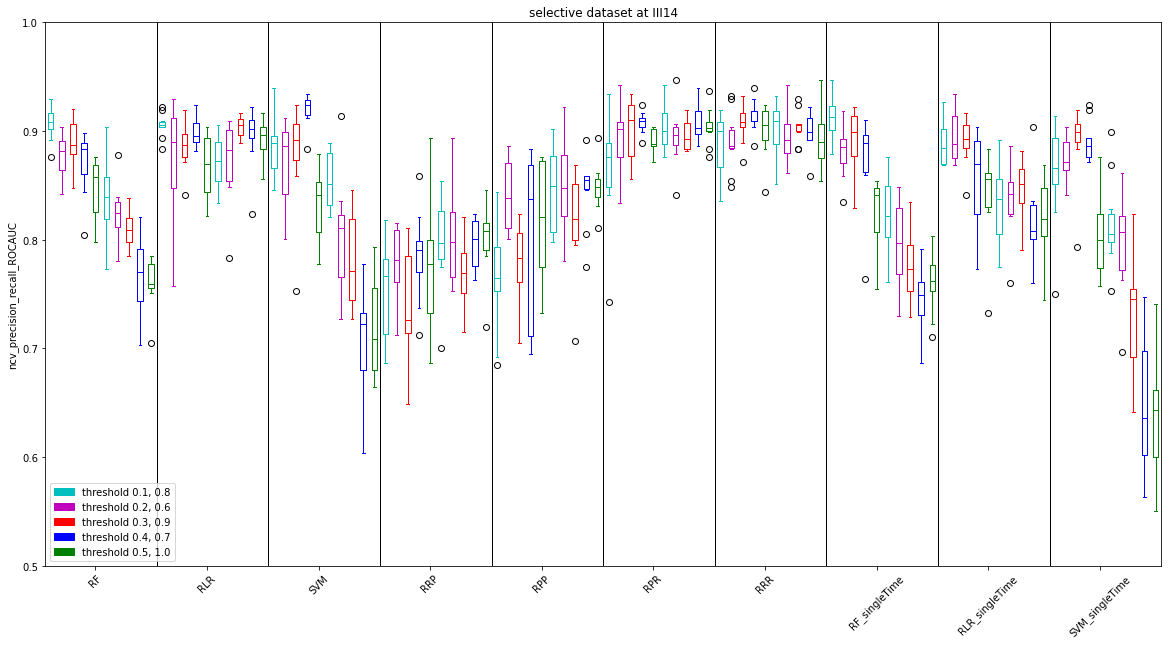

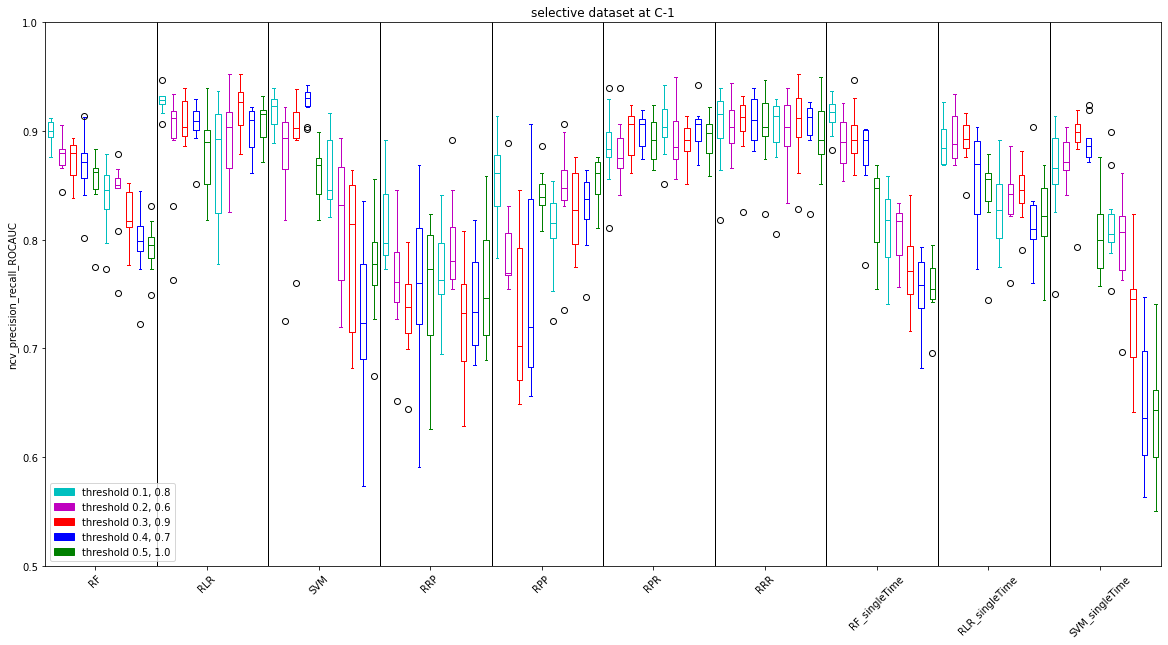

In [341]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0.5, 1))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("ncv_precision_recall_ROCAUC")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [342]:
# Dataholder for precision_recall_auc performance measurment 
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_ncv_precision_recall_auc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['mean_test_precision_recall_auc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['test_precision_recall_auc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['precision_recall_auc']), :]['ncv_precision_recall_auc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


In [343]:
results = calc_mean(results)
print('mean_threshold at whole_III14 for RRR' + ' ' + str(results['whole']['III14_ncv']['RRR'].loc['mean_thresholds']))
print('mean_threshold at whole_C-1 for RRR' + ' ' + str(results['whole']['C-1_ncv']['RRR'].loc['mean_thresholds']))
print('mean_threshold at selective_III14 for RRR' + ' ' + str(results['selective']['III14_ncv']['RRR'].loc['mean_thresholds']))
print('mean_threshold at selective_C-1 for RRR' + ' ' + str(results['selective']['C-1_ncv']['RRR'].loc['mean_thresholds']))
print('\n')
print('mean_threshold at whole_III14 for RPR' + ' ' + str(results['whole']['III14_ncv']['RPR'].loc['mean_thresholds']))
print('mean_threshold at whole_C-1 for RPR' + ' ' + str(results['whole']['C-1_ncv']['RPR'].loc['mean_thresholds']))
print('mean_threshold at selective_III14 for RPR' + ' ' + str(results['selective']['III14_ncv']['RPR'].loc['mean_thresholds']))
print('mean_threshold at selective_C-1 for RPR' + ' ' + str(results['selective']['C-1_ncv']['RPR'].loc['mean_thresholds']))
print('\n')
print('mean_threshold at whole_III14 for RLR' + ' ' + str(results['whole']['III14_ncv']['RLR'].loc['mean_thresholds']))
print('mean_threshold at whole_C-1 for RLR' + ' ' + str(results['whole']['C-1_ncv']['RLR'].loc['mean_thresholds']))
print('mean_threshold at selective_III14 for RLR' + ' ' + str(results['selective']['III14_ncv']['RLR'].loc['mean_thresholds']))
print('mean_threshold at selective_C-1 for RLR' + ' ' + str(results['selective']['C-1_ncv']['RLR'].loc['mean_thresholds']))

mean_threshold at whole_III14 for RRR 0.8998992021351795
mean_threshold at whole_C-1 for RRR 0.9136498249354865
mean_threshold at selective_III14 for RRR 0.8979570034085356
mean_threshold at selective_C-1 for RRR 0.9051502286849452
/n
mean_threshold at whole_III14 for RPR 0.9106507148720994
mean_threshold at whole_C-1 for RPR 0.9115692108206904
mean_threshold at selective_III14 for RPR 0.9054538823204636
mean_threshold at selective_C-1 for RPR 0.9065548806274277
/n
mean_threshold at whole_III14 for RLR 0.8805092766156614
mean_threshold at whole_C-1 for RLR 0.9148347135897723
mean_threshold at selective_III14 for RLR 0.8857635245426481
mean_threshold at selective_C-1 for RLR 0.9060792012477753


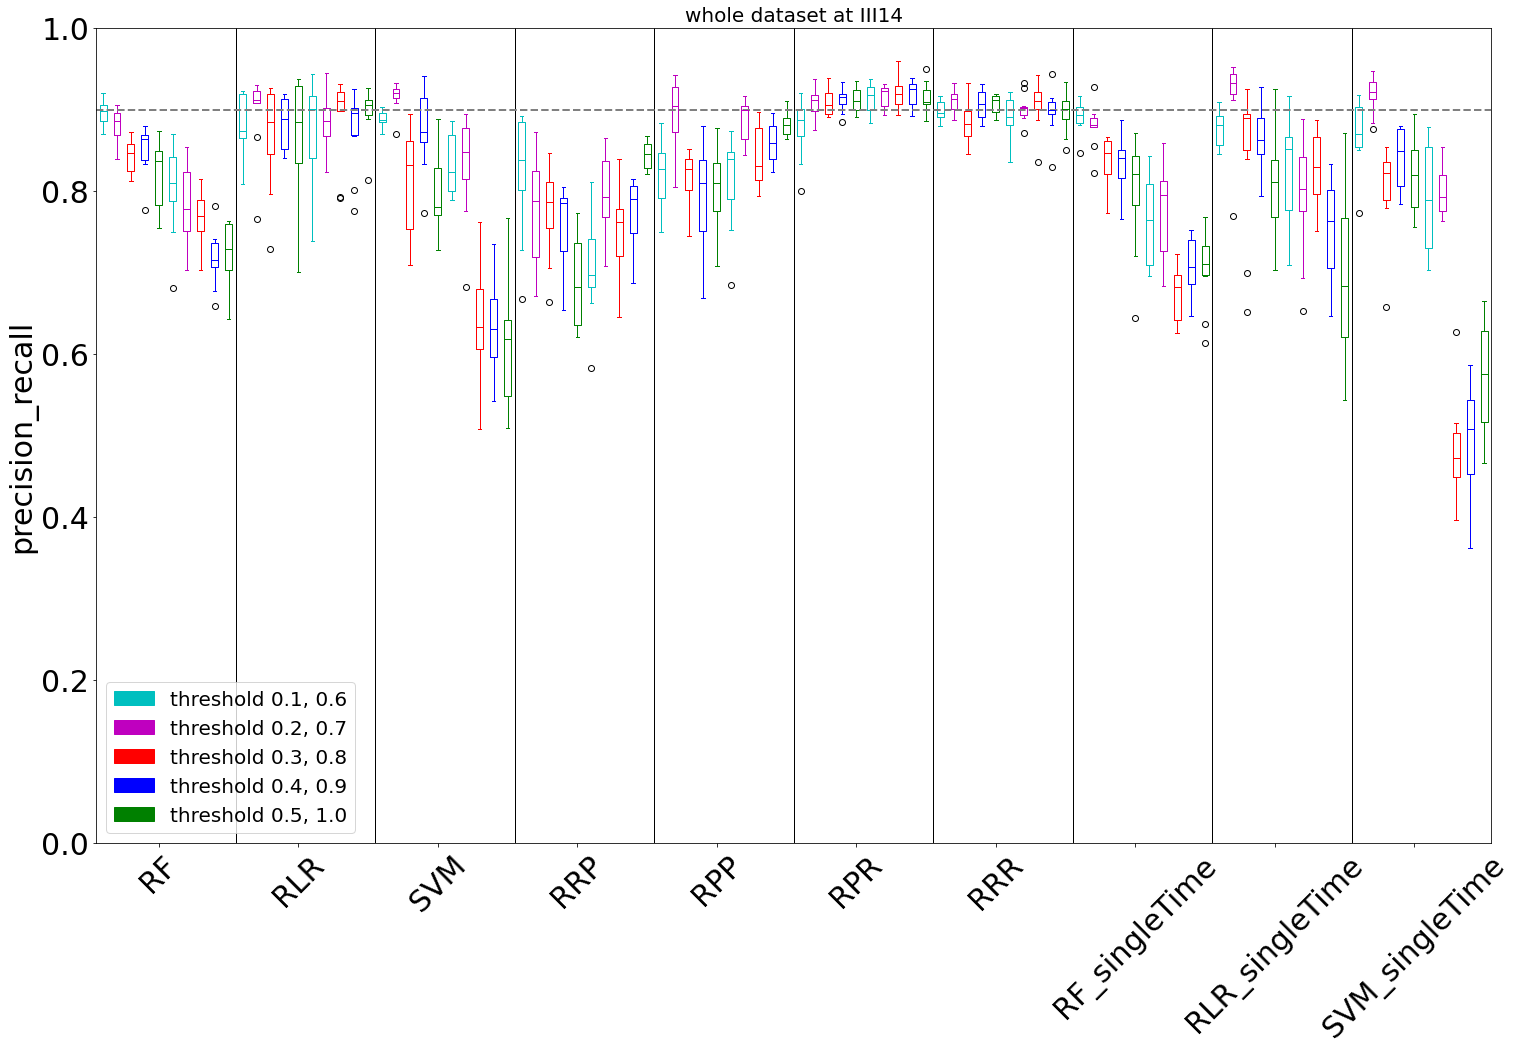

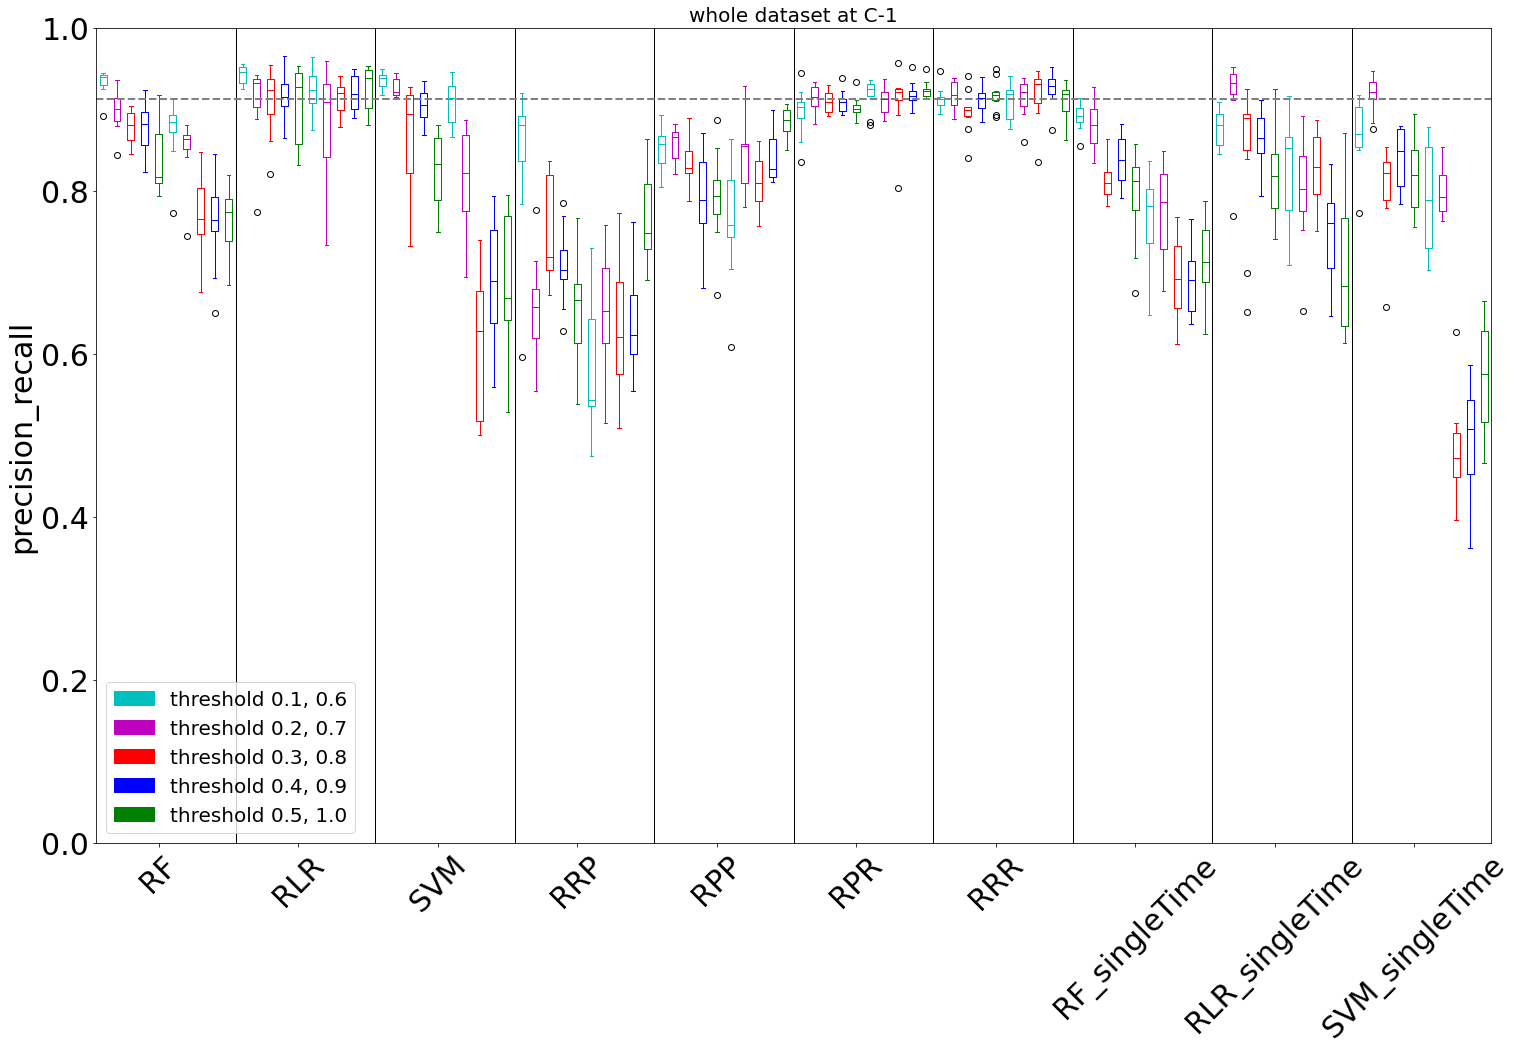

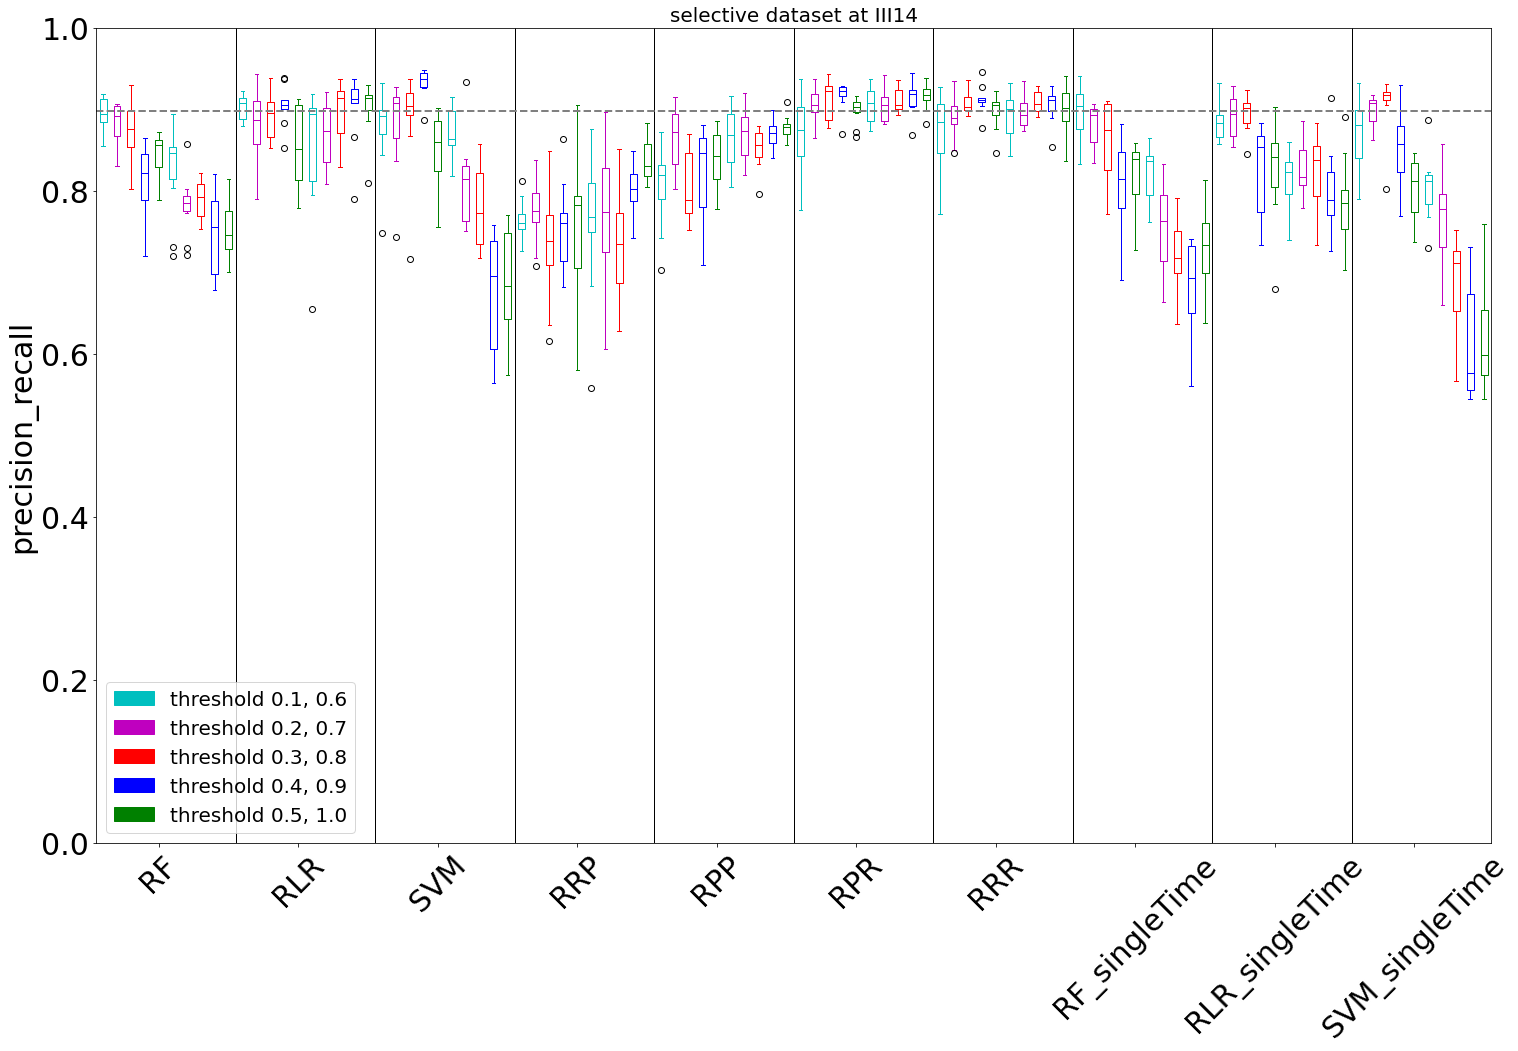

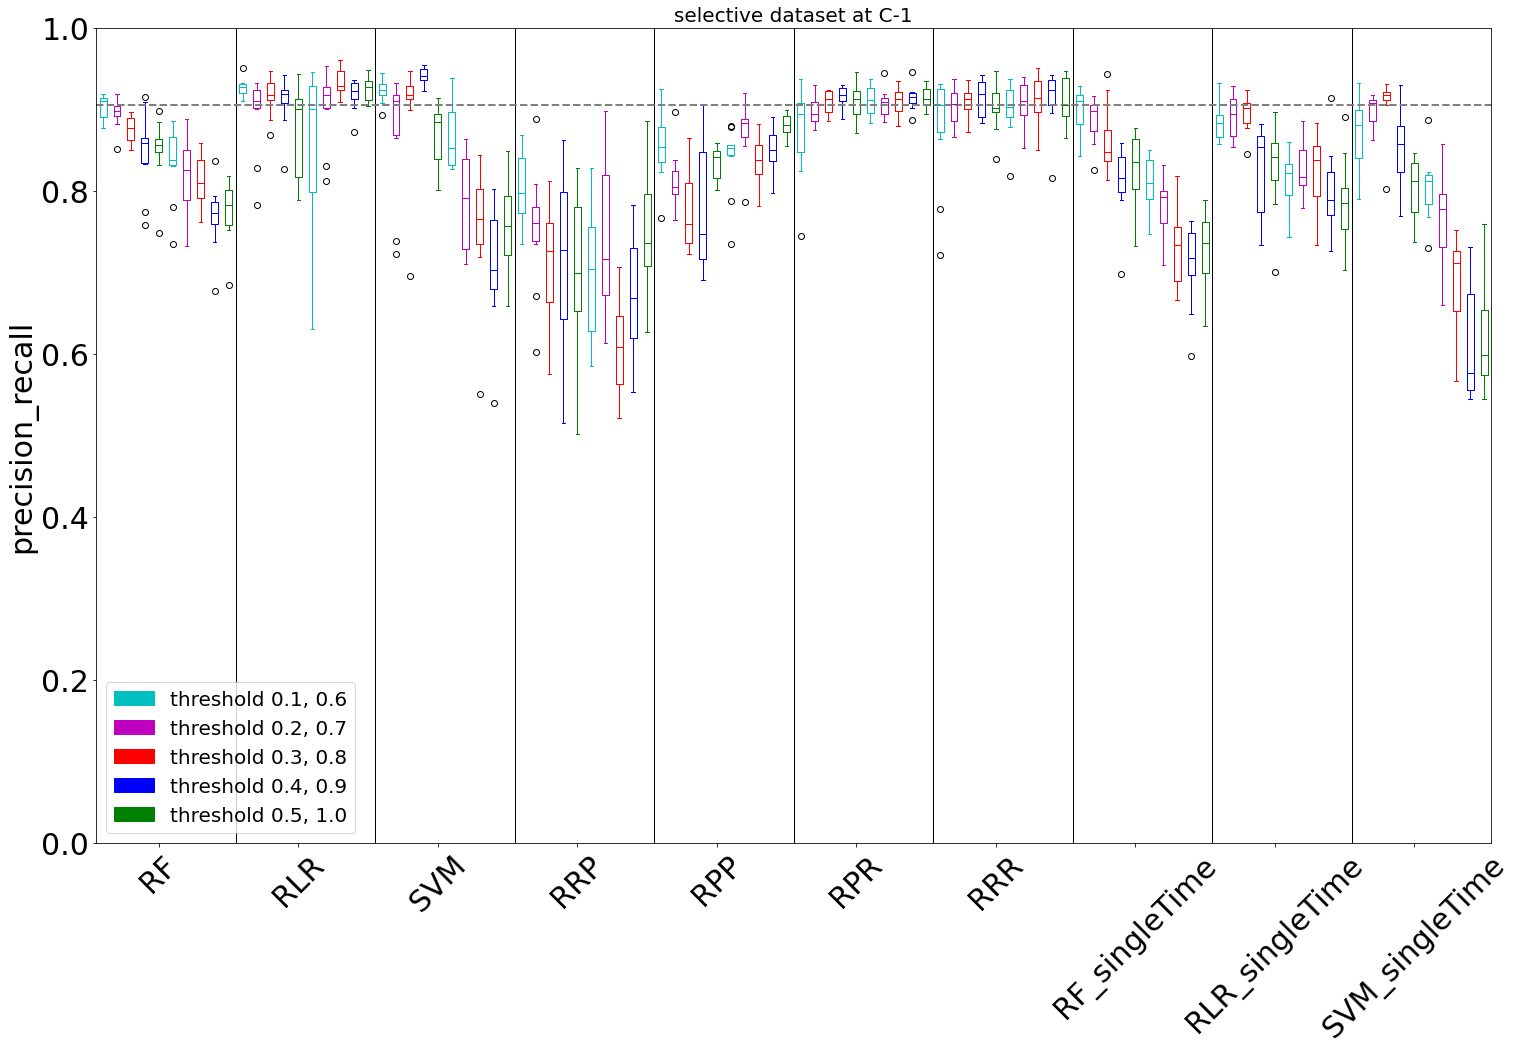

In [344]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(25, 15))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.6')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.7')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.8')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.9')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)), fontsize = 30)
        plt.ylim((0.0, 1))
        plt.yticks(fontsize = 30)
        plt.axhline(y=results[dataset][f'{time}_ncv']['RRR'].loc['mean_thresholds'],linestyle='--',linewidth=2, color='gray')
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch], fontsize = 20)
        plt.ylabel("precision_recall", fontsize = 30)
        plt.title(f"{dataset} dataset at {time}", fontsize = 20)
        plt.show()
        plt.close()

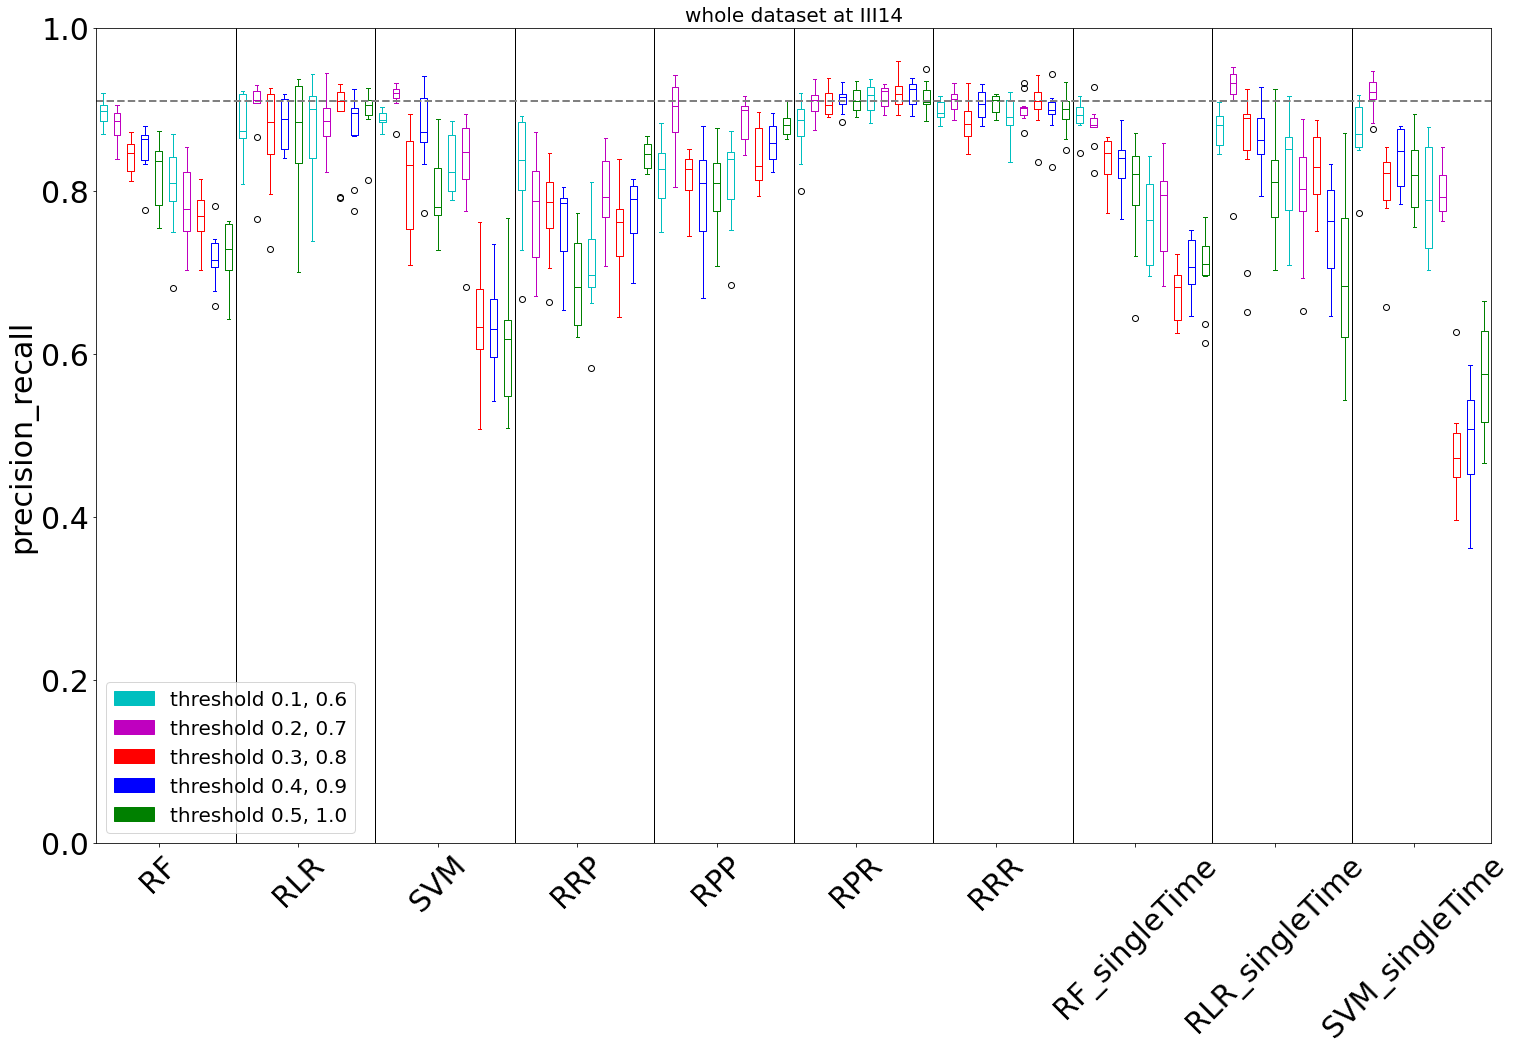

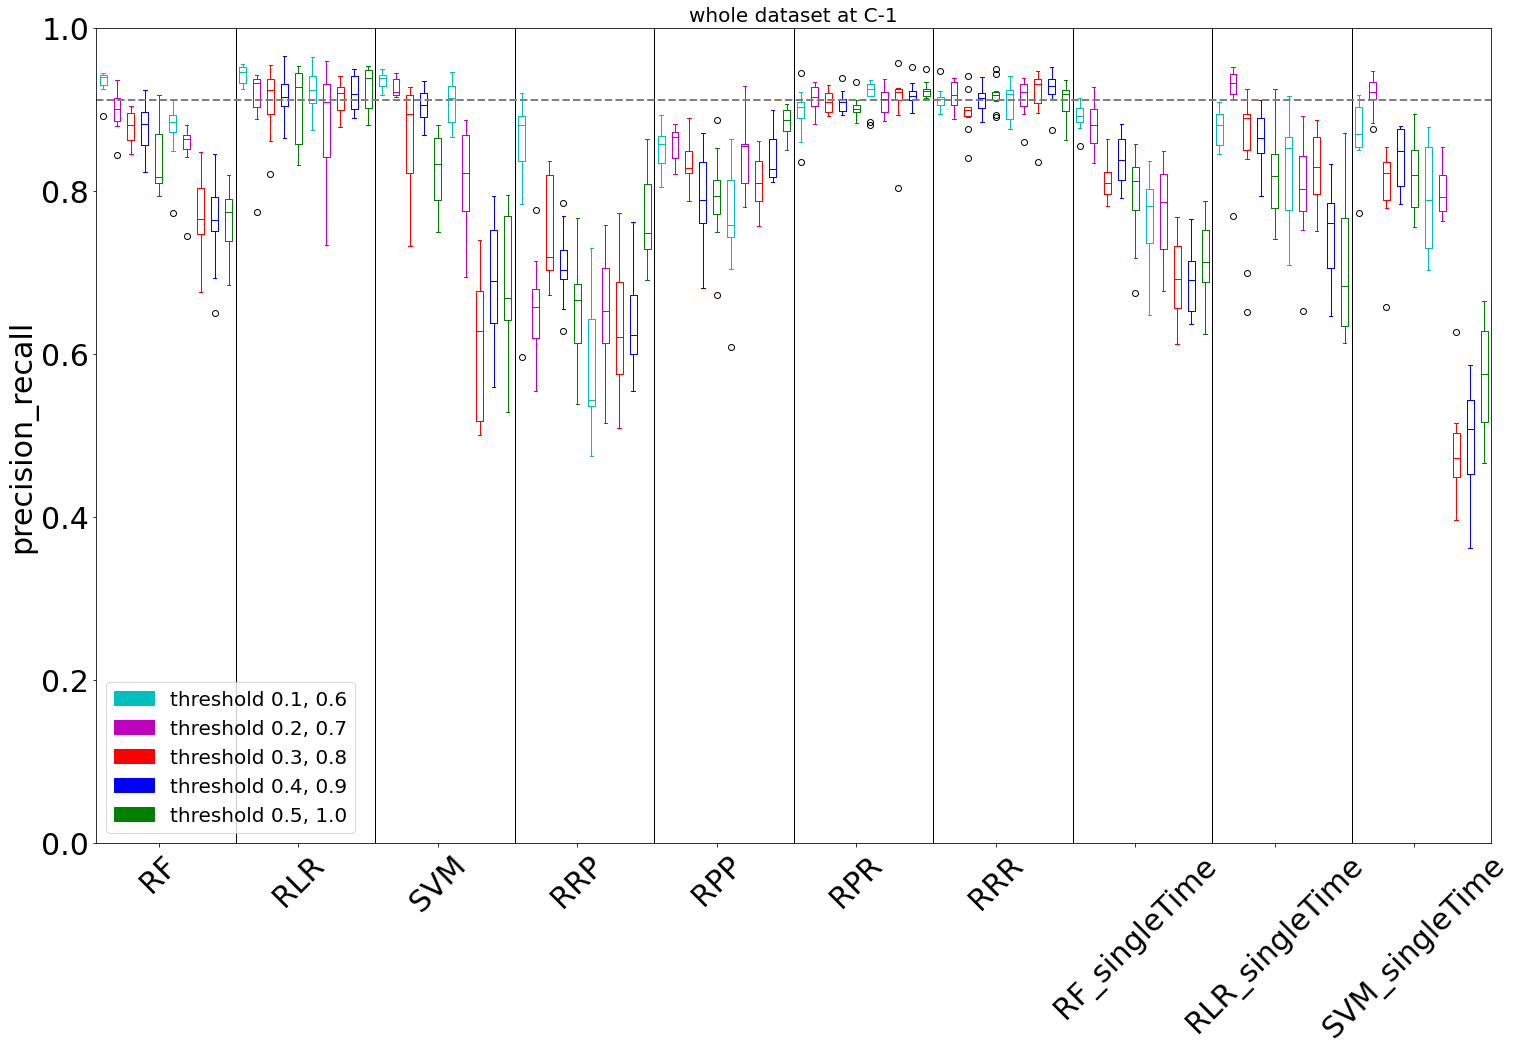

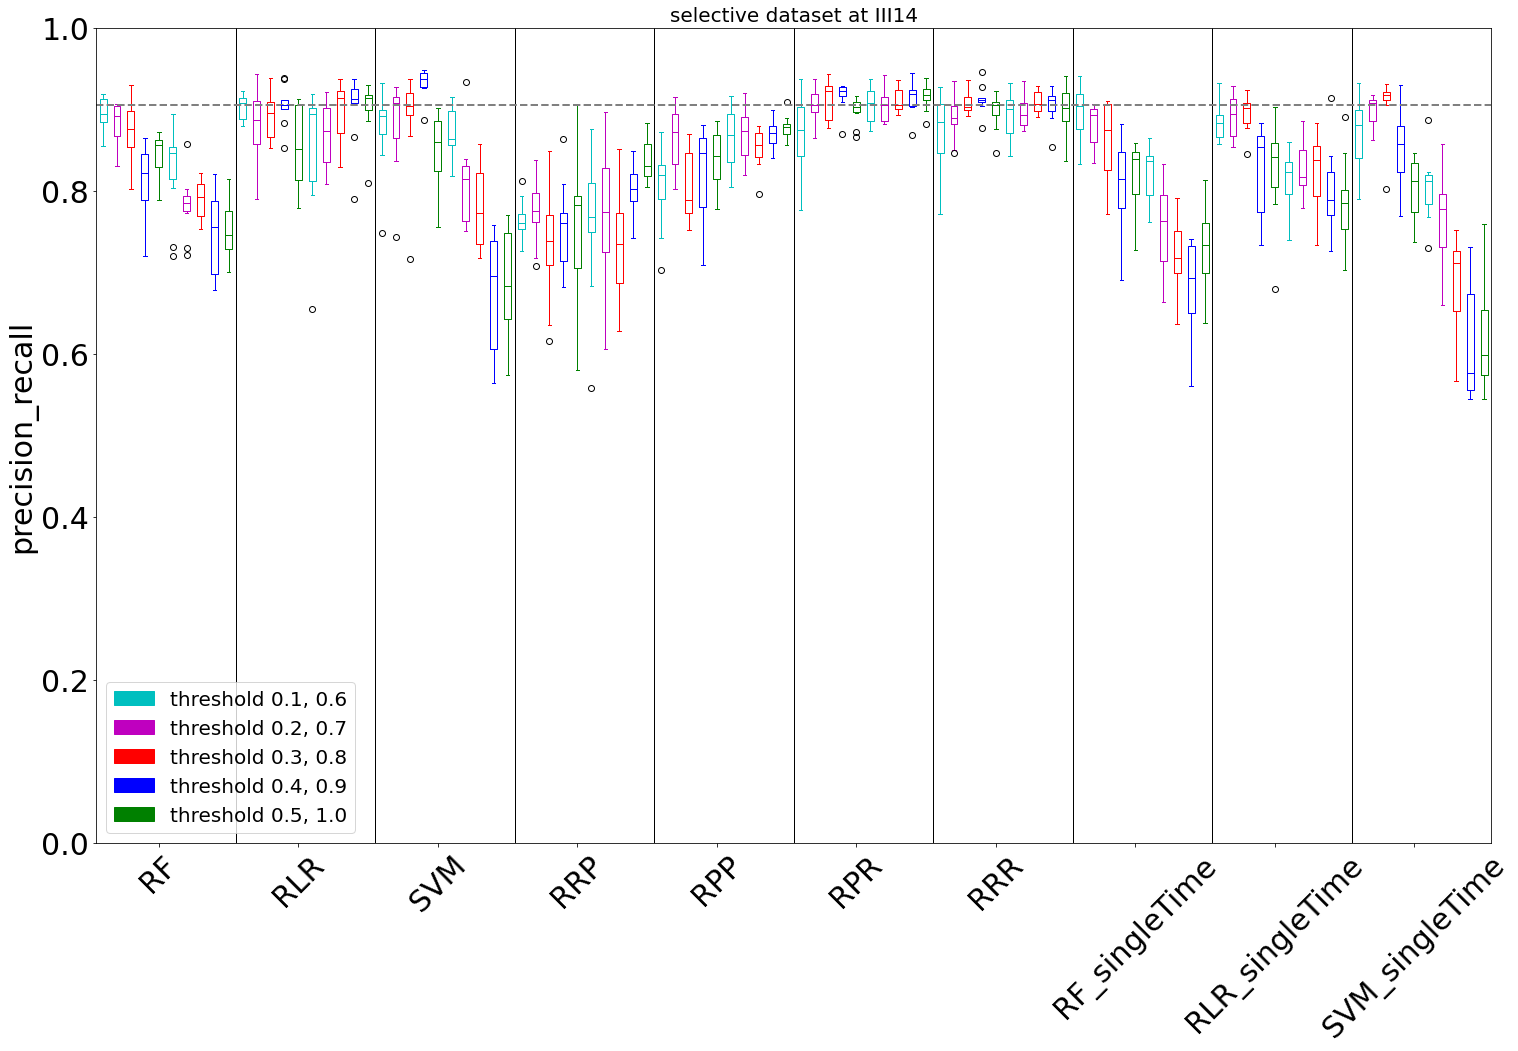

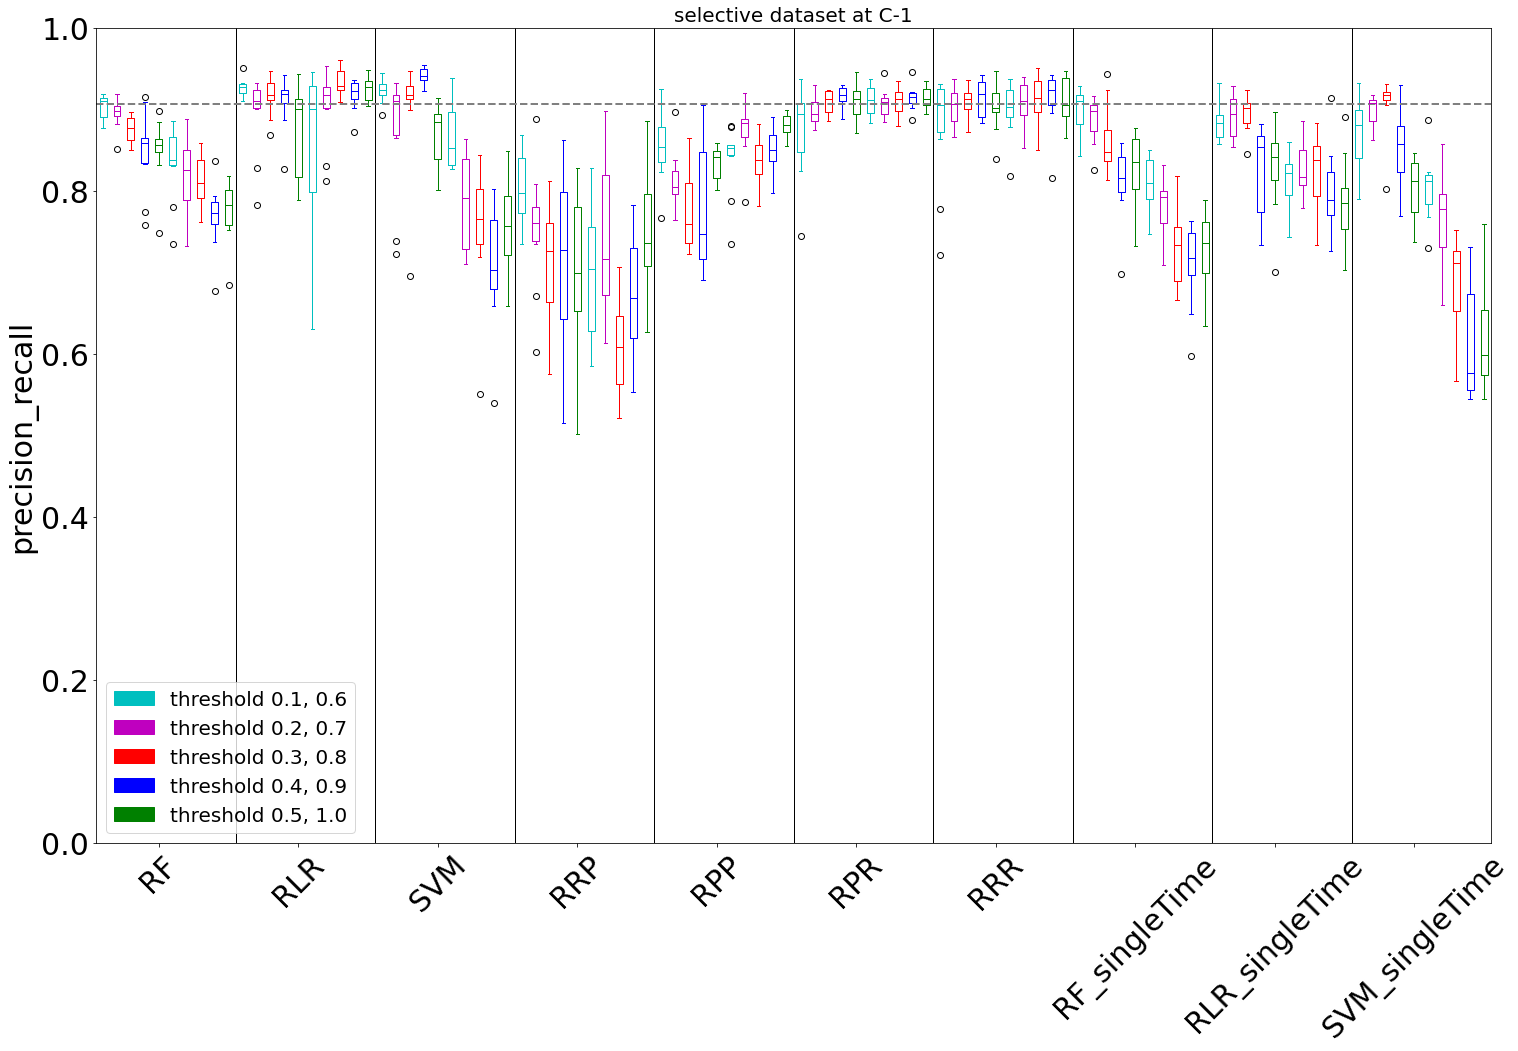

In [345]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(25, 15))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.6')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.7')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.8')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.9')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)), fontsize = 30)
        plt.ylim((0.0, 1))
        plt.yticks(fontsize = 30)
        plt.axhline(y=results[dataset][f'{time}_ncv']['RPR'].loc['mean_thresholds'],linestyle='--',linewidth=2, color='gray')
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch], fontsize = 20)
        plt.ylabel("precision_recall", fontsize = 30)
        plt.title(f"{dataset} dataset at {time}", fontsize = 20)
        plt.show()
        plt.close()

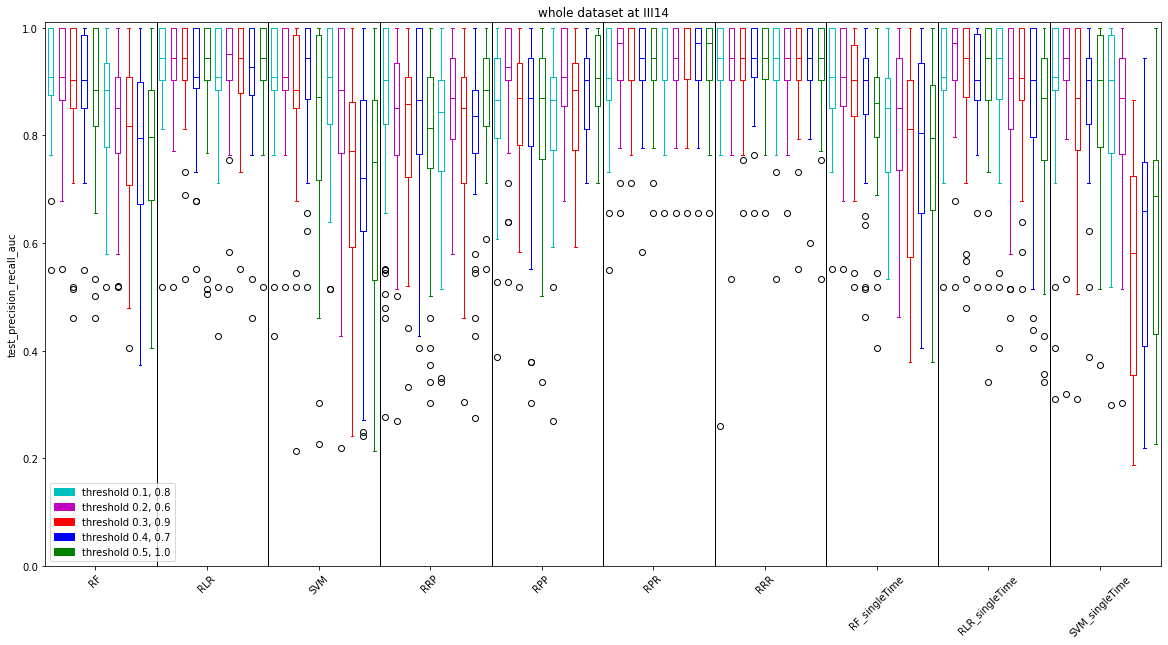

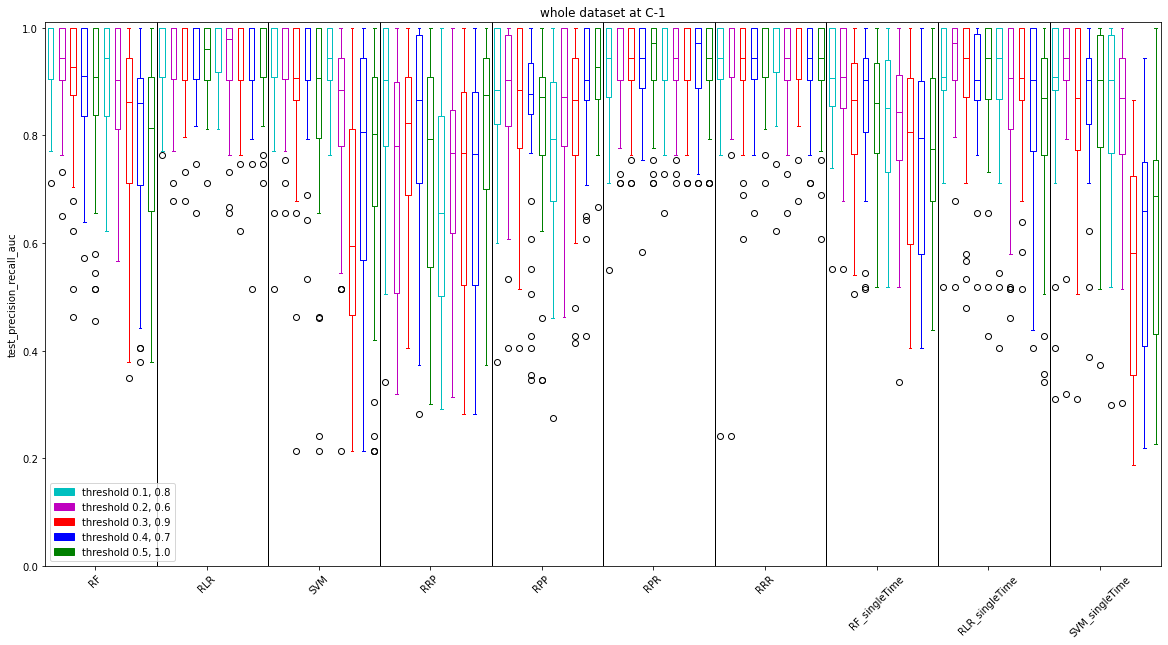

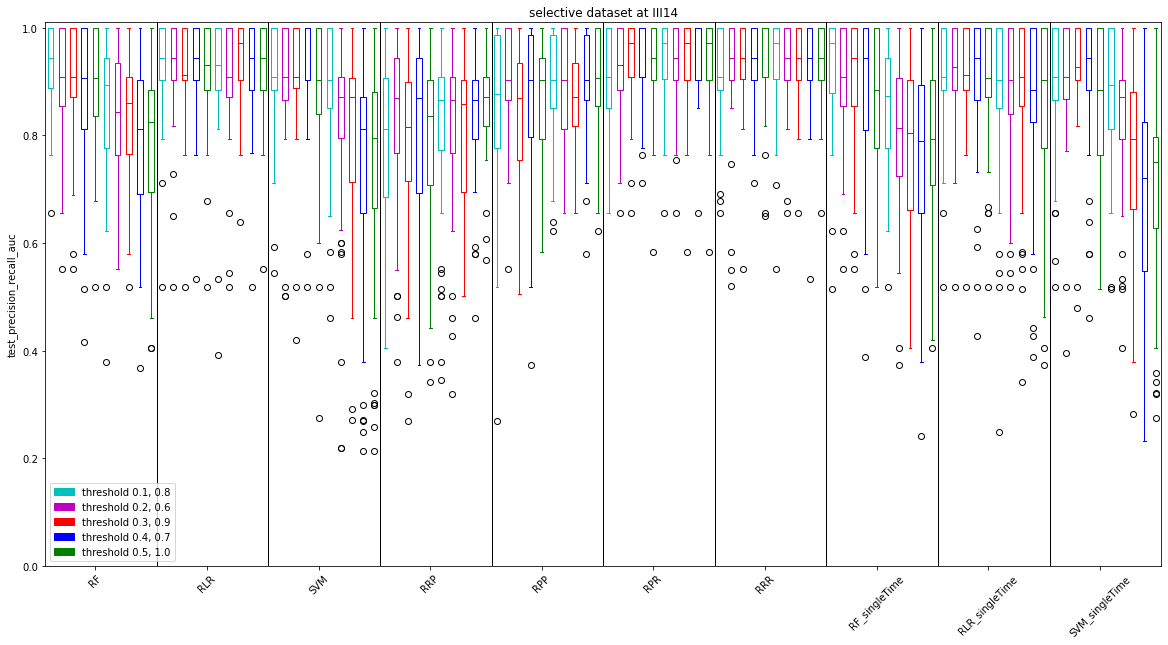

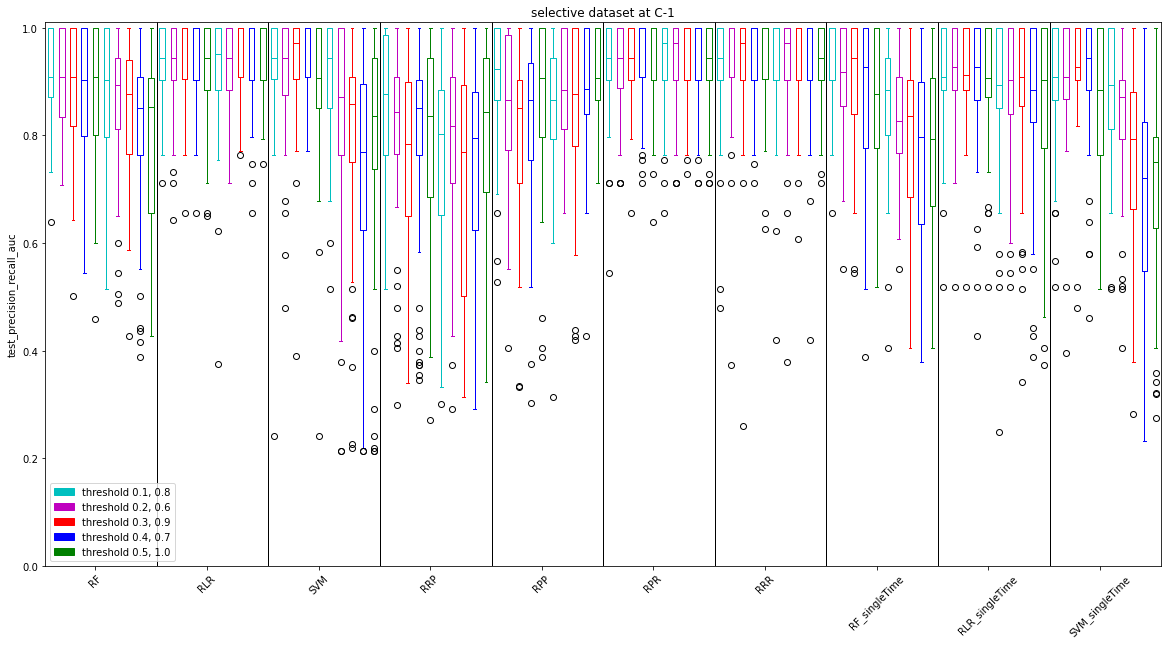

In [346]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_test'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1.01, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0, 1.01))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("test_precision_recall_auc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [347]:
# Dataholder for MCC performance measurment 
combis = ['RRP', 'RPP', 'RPR', 'RRR']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
methods = ['RF', 'RLR', 'SVM', 'multitaskSVM']
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
#columns = ['RF_multiTime', 'RLR_multiTime', 'SVM_multiTime', 'RRP_multiTime', 'RPP_multiTime', 'RPR_muliTime', 'RRR_multiTime']
times = ['III14', 'C-1']
results = {
    'whole': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
    'selective': {
        'III14_test': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'III14_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_test_conf': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_mean': pd.DataFrame(index=thresholds, columns=columns),
        'C-1_ncv_conf': pd.DataFrame(index=thresholds, columns=columns),
        
    },
}
result_dir="/Users/schmidtj/MalariaVaccineEfficacyPrediction/results"
#print(results)
for threshold in thresholds:
    for method in methods:
        maindir = f"{result_dir}/threshold{threshold}/{method}"
        for dataset in ['whole', 'selective']:
                for analysis_time in ['multiTime', 'singleTime']:
                    if method == 'multitaskSVM' and analysis_time =='multiTime':
                        for combination in combis:
                            ana_dir = f"{maindir}/{dataset}/{combination}/{analysis_time}/RNCV"
                            #print(ana_dir)
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                #print(temp)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, combination={combination}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, combination] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_ncv_mcc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, combination] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_test_mcc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, combination] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, combination] = [ci_l, ci_u]

                    else:
                        if analysis_time == 'singleTime':
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                        
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                                
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:
                                
                                results[dataset][f'{time}_ncv'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10)
                                
                                results[dataset][f'{time}_test'].loc[threshold, f'{method}_{analysis_time}'] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_ncv_mcc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold,f'{method}_{analysis_time}'] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_test_mcc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, f'{method}_{analysis_time}'] = [ci_l, ci_u]
                            
                            # index method muss noch die analysis zeit mit dazu bekommen!
                        else:
                        
                            ana_dir = f"{maindir}/{dataset}/{analysis_time}/RNCV"
                            fn = os.path.join(ana_dir, "collected_key_results.tsv")
                            try:
                                temp =  pd.read_csv(fn, sep='\t', index_col=0)
                            except:
                                print(f"No results found for threshold={threshold}, method={method}, dataset={dataset}, analysis_time={analysis_time}.")
                                continue
                            for time in times:

                                results[dataset][f'{time}_ncv'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10)

                                results[dataset][f'{time}_test'].loc[threshold, method] = stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50)

                                results[dataset][f'{time}_ncv_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_ncv_mcc'].values[0]

                                results[dataset][f'{time}_test_mean'].loc[threshold, method] = temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['mean_test_mcc'].values[0]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['test_mcc'].values[0], length=50),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_test_conf'].loc[threshold, method] = [ci_l, ci_u]

                                ci_l, ci_u = bootstrap((stripper(temp.loc[temp['time'].isin([time]), :].loc[temp['scoring'].isin(['mcc']), :]['ncv_mcc'].values[0], length=10),), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=1337).confidence_interval
                                results[dataset][f'{time}_ncv_conf'].loc[threshold, method] = [ci_l, ci_u]
                            
                                


No results found for threshold=0.1, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.1, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.2, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.3, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.4, method=multitaskSVM, dataset=selective, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=whole, analysis_time=singleTime.
No results found for threshold=0.5, method=multitaskSVM, dataset=selective, analysis_time=singleTime.


In [348]:
results['whole']['III14_test_conf']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.5521262682232073, 0.7030404293443143]","[0.6130244573156466, 0.735169585912679]","[0.5877602786513856, 0.7298076760231436]","[0.5208525762604881, 0.6982787128150424]","[0.41205738580916773, 0.567531251750192]","[0.5742160774800438, 0.7021413493463691]","[0.5117815868642739, 0.6862753146706965]","[0.5671588491360907, 0.6994726415424563]","[0.6221565573476654, 0.7342273261978874]","[0.5611229084165641, 0.715470542121171]"
0.2,"[0.5669380286842411, 0.7022981228914207]","[0.6212230170569151, 0.7540461088062379]","[0.6592631441691724, 0.7752700266798852]","[0.4660234739414216, 0.6220787309960859]","[0.5028227199046359, 0.6411498753010847]","[0.6730469771839075, 0.786306611325299]","[0.5804150583835209, 0.7154315078575236]","[0.5823745085916794, 0.7127240302742676]","[0.6429542735661907, 0.76050929932675]","[0.6214641454632156, 0.7396044428158729]"
0.3,"[0.5992983141132131, 0.7159572400035827]","[0.5870441432200434, 0.7223176625315506]","[0.5025774000207861, 0.6555362215771522]","[0.29464686282301933, 0.4575454998082302]","[0.5117839658688026, 0.637893966719712]","[0.6033105470353057, 0.7127553725724199]","[0.6011217751634655, 0.7389097036118686]","[0.537924766436955, 0.6807755472877175]","[0.5636203368990268, 0.7032167172415514]","[0.45359164988019784, 0.6094645458768749]"
0.4,"[0.5910796705437263, 0.7046602122001021]","[0.5567150762864577, 0.7022447222165047]","[0.6096224683460799, 0.751494514662691]","[0.4978901039035704, 0.6340732881050473]","[0.40725961871600613, 0.5529225696296569]","[0.6315207648078506, 0.749092056861183]","[0.6229925170257499, 0.7515394680779325]","[0.5029781649905208, 0.630209846414146]","[0.5678108987927732, 0.7025342242720204]","[0.5200745545454944, 0.6728419249869281]"
0.5,"[0.5128041562461932, 0.650990772933621]","[0.5902276273411485, 0.7240933735845609]","[0.49274531375434055, 0.6463943430970237]","[0.25312016477784943, 0.42751326646389365]","[0.411044110881396, 0.5390119253908415]","[0.6609139921414955, 0.7827571102570139]","[0.6070790787335255, 0.739251003629572]","[0.43444771030281115, 0.5983504650569299]","[0.5612123402158133, 0.6991662726488643]","[0.44838319036631946, 0.5991408682009055]"
0.6,"[0.5018472948054339, 0.6215669377349264]","[0.7038549290077333, 0.8117770765477329]","[0.4616978936924415, 0.6194536411371119]","[0.37091158895008663, 0.5264661959718746]","[0.4012898446160236, 0.5596891289902269]","[0.6684660394956301, 0.7851582515710551]","[0.6499647760507359, 0.774173655719268]","[0.4200723424013873, 0.5507917609368794]","[0.5750020780929205, 0.7144735027993006]","[0.4961627616529238, 0.6641927378067326]"
0.7,"[0.3910150049638184, 0.537918484875448]","[0.6595754878886887, 0.7807981437993704]","[0.47319310016238086, 0.6535598975978576]","[0.5224855358318162, 0.659484277557911]","[0.5215377187207435, 0.653262446414807]","[0.6489541525299048, 0.763109959908366]","[0.6471086058708715, 0.7682991659124468]","[0.36673611516273863, 0.5187699571951394]","[0.5903030983023381, 0.7044270483347947]","[0.43492786108378984, 0.5739932862642462]"
0.8,"[0.3523205352225191, 0.4888256750798192]","[0.6544537787533613, 0.782634416908673]","[0.24179374293478095, 0.3893049869779797]","[0.45044005334475196, 0.5921575322027434]","[0.49160327891224265, 0.615243594602518]","[0.6792833582796534, 0.7959944732174231]","[0.6468975568244254, 0.7715176656627027]","[0.40313884525279503, 0.5328400597574032]","[0.5193768690245057, 0.6548971734952921]","[0.11621572365309478, 0.2873799603042965]"
0.9,"[0.3357789431028926, 0.4913424680109214]","[0.5921191203729834, 0.7404235375249822]","[0.3013190471159099, 0.4651121273484211]","[0.45262247520794696, 0.6020028993454509]","[0.5209664827114963, 0.6446792439026934]","[0.6460541181487272, 0.7756617182936351]","[0.6474369202407113, 0.766364792837655]","[0.3710782646987166, 0.5277393984479007]","[0.4210006108845052, 0.5935130475856718]","[0.25902231839724904, 0.3988724526815526]"
1.0,"[0.3586461570417600

In [349]:
results['whole']['III14_test']

,RF,RLR,SVM,RRP,RPP,RPR,RRR,RF_singleTime,RLR_singleTime,SVM_singleTime
0.1,"[0.77459667, 0.25819889, 0.5, 1.0, 1.0, 0.5773...","[0.77459667, 0.57735027, 0.5, 0.77459667, 0.77...","[0.77459667, 0.25819889, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.57735027, 0.77459667, 1.0, 1.0,...","[1.0, 0.57735027, 0.25819889, 0.77459667, 0.77...","[0.77459667, 0.57735027, 0.5, 0.77459667, 0.74...","[0.77459667, 0.25819889, 0.5, 0.77459667, 1.0,...","[1.0, 0.57735027, 0.5, 0.77459667, 1.0, 0.3779...","[0.77459667, 0.57735027, 0.5, 0.77459667, 0.77...","[0.77459667, 0.25819889, 0.5, 1.0, 1.0, 0.5773..."
0.2,"[0.5, 0.25819889, 0.5, 0.77459667, 1.0, 0.5773...","[0.77459667, 0.25819889, 0.5, 1.0, 1.0, 0.5773...","[0.77459667, 0.57735027, 0.5, 0.77459667, 1.0,...","[0.37796447, 0.25819889, 0.25819889, 1.0, 0.44...","[0.57735027, 0.57735027, 0.5, 0.46666667, 0.77...","[0.77459667, 0.77459667, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.5, 0.5, 0.4472136, 0.77459667, ...","[1.0, 0.5, 0.5, 0.77459667, 0.77459667, 0.5773...","[0.77459667, 0.57735027, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.25819889, 0.5, 0.77459667, 1.0,..."
0.3,"[0.77459667, 0.5, 0.5, 0.77459667, 0.77459667,...","[0.77459667, 0.25819889, 0.5, 0.77459667, 0.77...","[0.57735027, 0.57735027, 0.5, 0.77459667, 0.6,...","[0.37796447, 0.25819889, 0.0, 0.74535599, 0.46...","[0.57735027, 0.77459667, 0.25819889, 0.4666666...","[0.57735027, 0.77459667, 0.5, 0.77459667, 1.0,...","[0.25819889, 0.77459667, 0.5, 0.77459667, 1.0,...","[0.57735027, 0.77459667, 0.5, 0.77459667, 0.77...","[0.77459667, 0.57735027, 0.5, 0.77459667, 0.77...","[0.57735027, 0.57735027, 0.5, 0.77459667, 0.74..."
0.4,"[0.5, 0.57735027, 0.5, 0.77459667, 0.77459667,...","[0.77459667, 0.0, 0.5, 0.77459667, 1.0, 0.5773...","[0.77459667, 0.0, 0.77459667, 0.77459667, 0.74...","[0.57735027, 0.37796447, 0.5, 0.74535599, 1.0,...","[0.5, 0.57735027, 0.57735027, 0.77459667, 0.74...","[0.57735027, 0.77459667, 0.5, 0.77459667, 0.74...","[0.77459667, 0.25819889, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.57735027, 0.5, 0.46666667, 0.77...","[0.77459667, 0.57735027, 0.77459667, 0.7745966...","[0.5, 0.25819889, 0.77459667, 0.77459667, 0.74..."
0.5,"[0.77459667, 0.25819889, 0.5, 0.77459667, 0.6,...","[0.77459667, 0.25819889, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.5, 0.77459667, 0.77459667, 0.25...","[0.0, 0.25819889, -0.25819889, 0.46666667, 0.2...","[0.37796447, 0.57735027, 0.57735027, 0.7745966...","[0.77459667, 0.77459667, 0.5, 0.77459667, 0.74...","[0.77459667, 0.5, 0.5, 0.77459667, 0.77459667,...","[0.77459667, 0.57735027, 0.25819889, 0.7745966...","[0.77459667, 0.57735027, 0.25819889, 0.7745966...","[0.57735027, 0.25819889, 0.25819889, 0.7745966..."
0.6,"[0.77459667, 0.25819889, 0.5, 0.77459667, 0.6,...","[0.77459667, 0.5, 0.77459667, 0.77459667, 1.0,...","[0.57735027, 0.5, 0.5, 0.1490712, 0.77459667, ...","[0.0, 0.57735027, 0.5, 0.46666667, 0.6, 0.2581...","[0.37796447, 0.57735027, 0.37796447, 0.1490712...","[0.77459667, 0.57735027, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.77459667, 0.5, 0.77459667, 0.77...","[0.5, 0.57735027, 0.25819889, 0.46666667, 0.6,...","[0.77459667, 0.77459667, 0.77459667, 0.7745966...","[0.77459667, 0.25819889, 0.25819889, 0.7745966..."
0.7,"[0.77459667, 0.57735027, 0.5, 0.46666667, 0.44...","[0.77459667, 0.77459667, 0.5, 0.77459667, 0.77...","[0.0, 0.77459667, 0.5, 0.74535599, 0.6, 0.7745...","[0.0, 0.57735027, 0.0, 0.77459667, 0.77459667,...","[0.57735027, 0.57735027, 0.57735027, 0.4666666...","[0.77459667, 0.57735027, 0.5, 0.77459667, 1.0,...","[0.77459667, 0.5, 0.5, 0.77459667, 1.0, 0.7745...","[0.5, 0.57735027, 0.25819889, 0.74535599, 0.44...","[0.57735027, 0.77459667, 0.5, 0.77459667, 1.0,...","[0.37796447, 0.77459667, 0.25819889, 0.4666666..."
0.8,"[0.25819889, 0.57735027, 0.25819889, 0.7453559...","[0.77459667, 0.77459667, 0.5, 0.77459667, 1.0,...","[0.25819889, 0.0, 0.25819889, -0.06666667, 0.6...","[0.25819889, 0.57735027, 0.25819889, 0.7745966...","[0.57735027, 0.57735027, 0.57735027, 0.7453559.

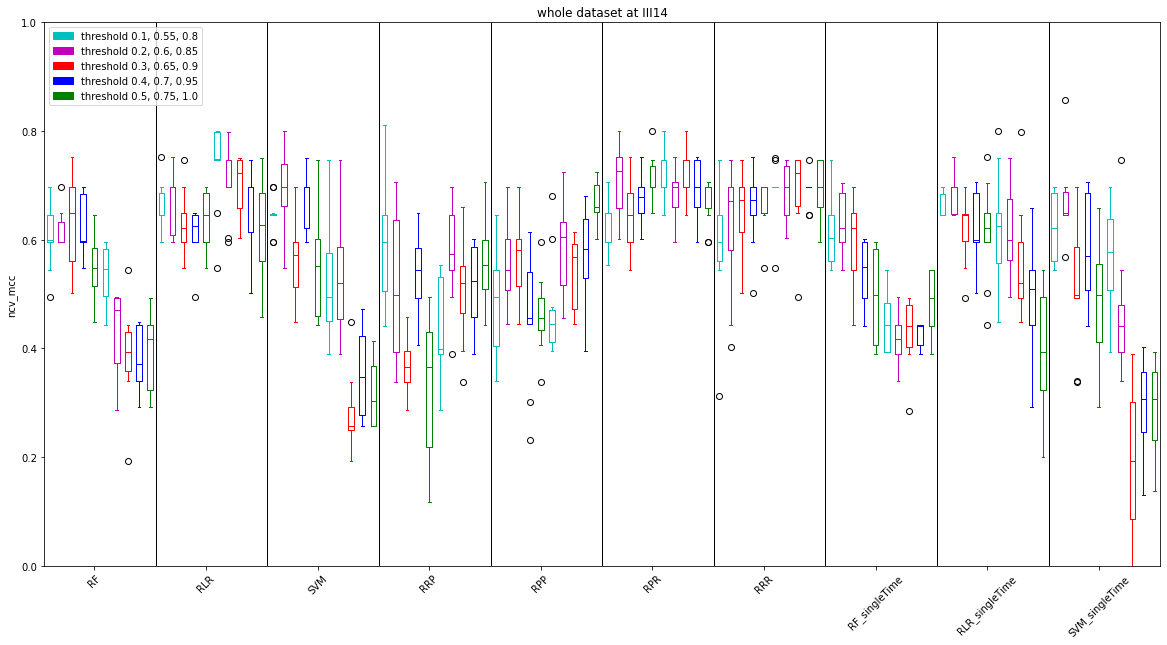

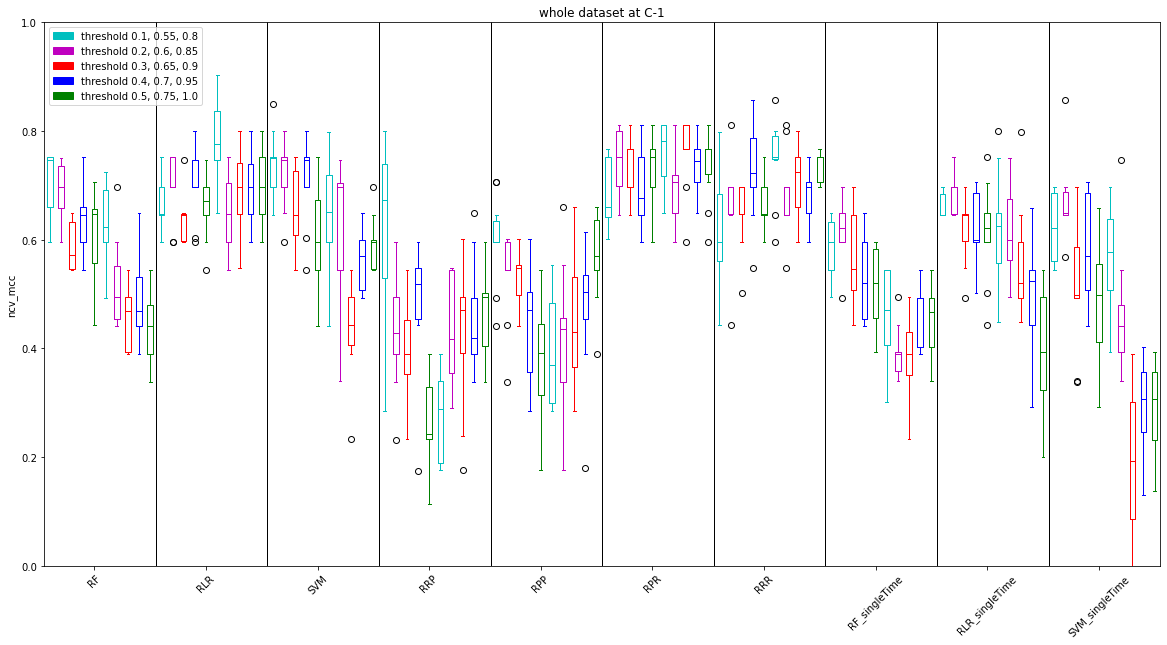

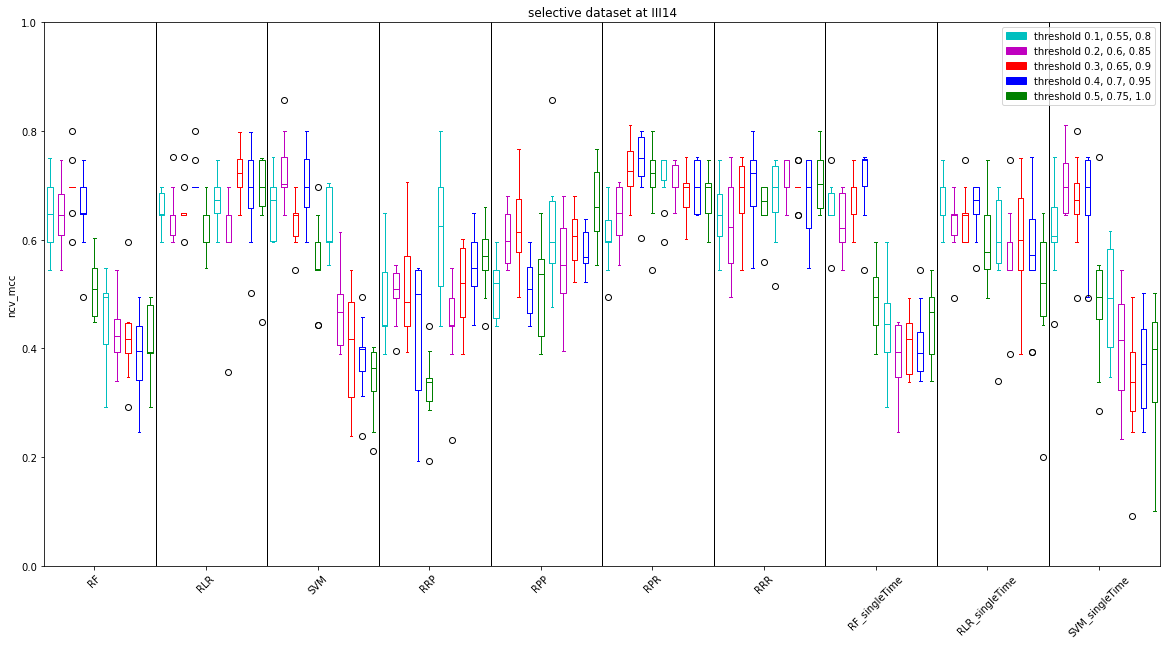

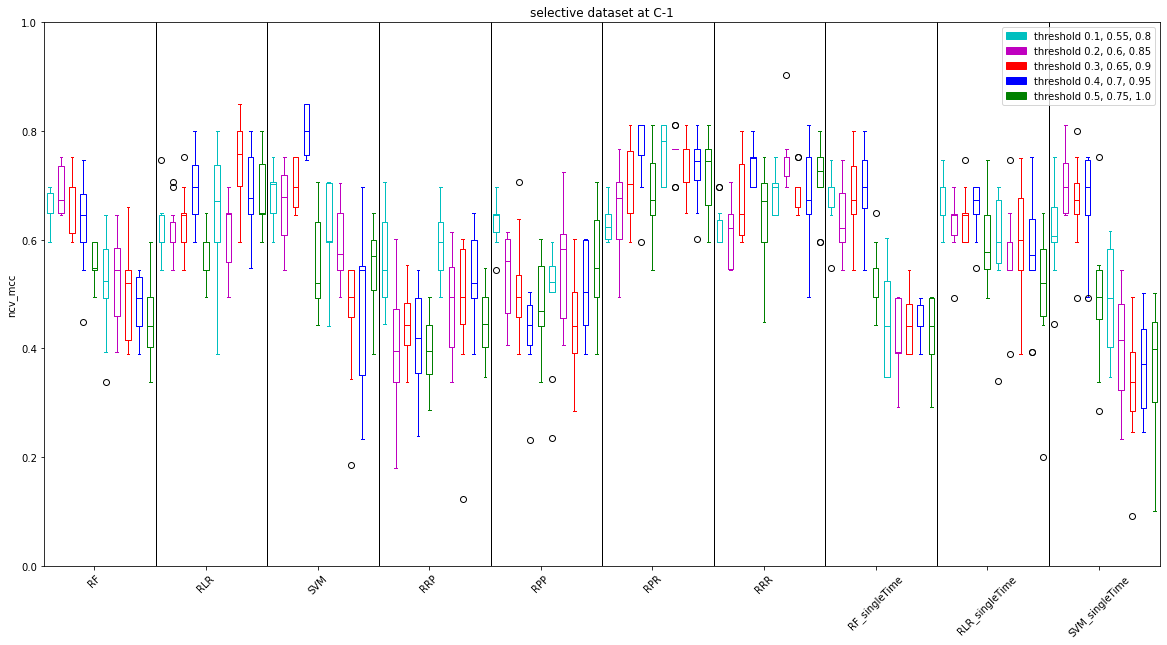

In [350]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_ncv'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, 0, 1, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((0, 1))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("ncv_mcc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

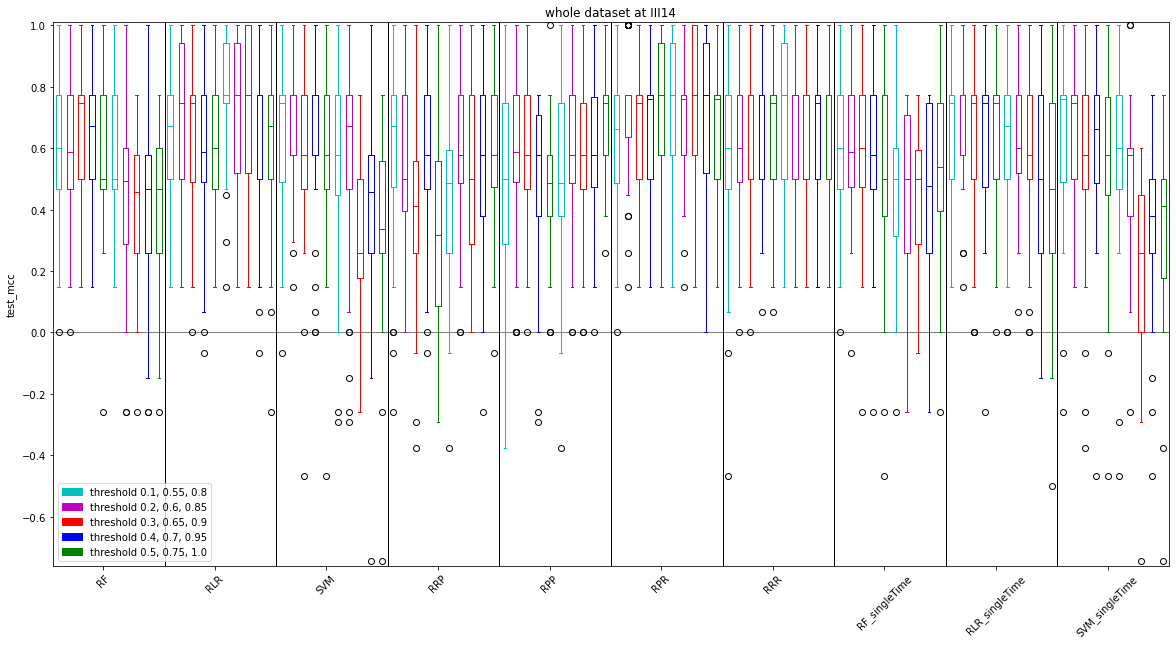

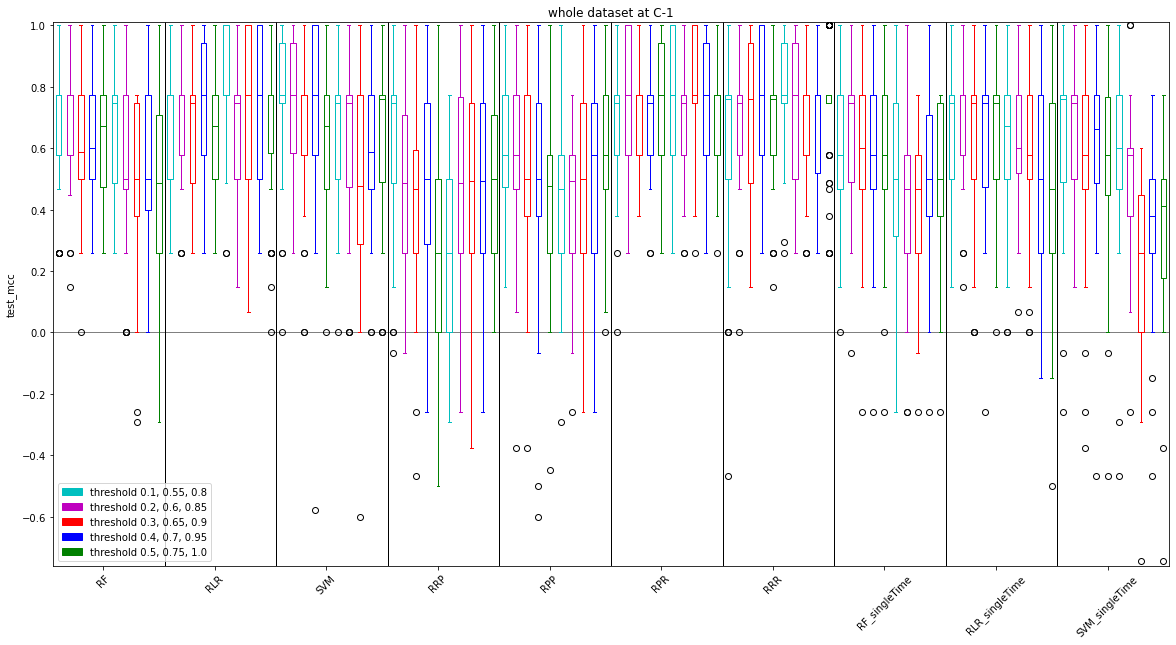

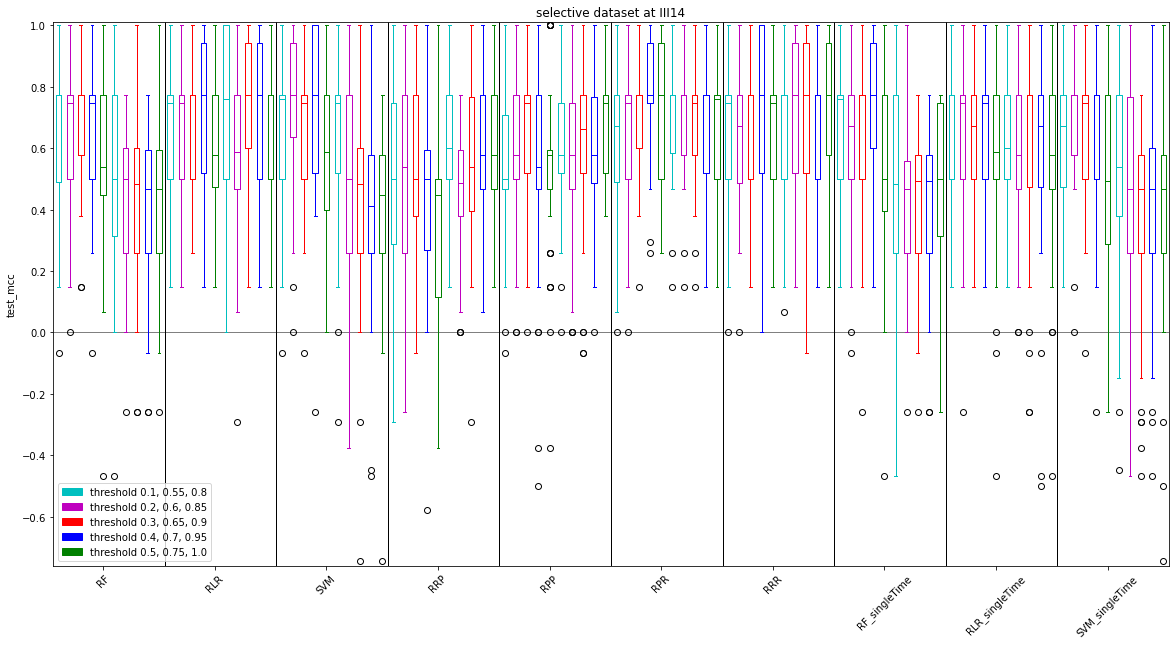

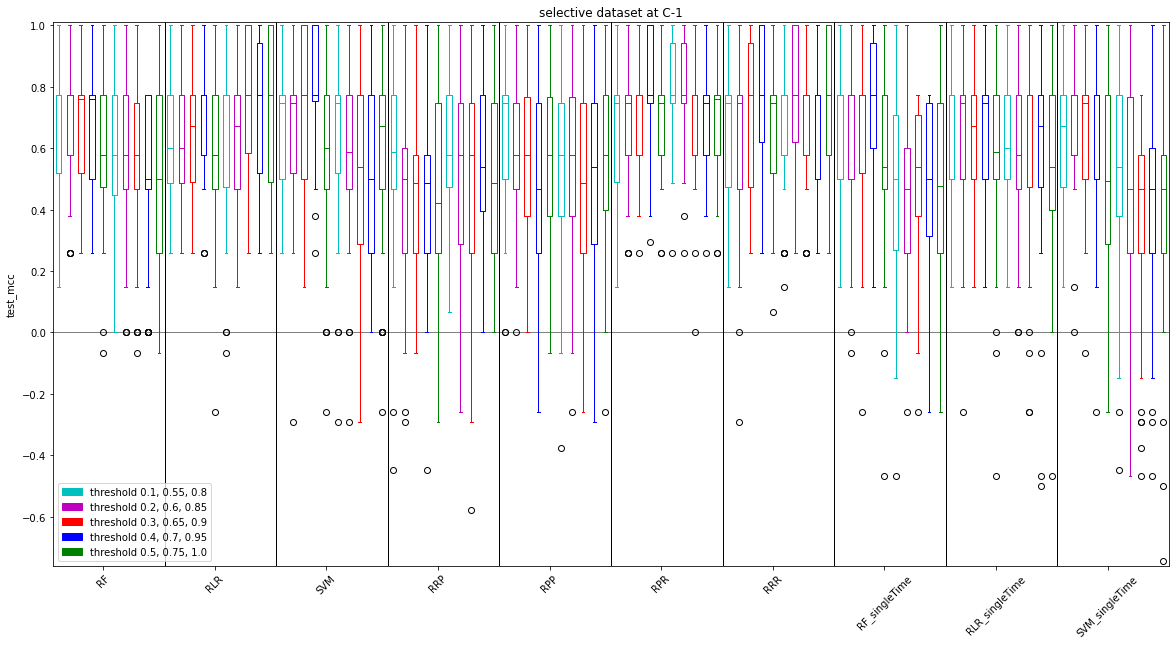

In [351]:
columns = ['RF', 'RLR', 'SVM', 'RRP', 'RPP', 'RPR', 'RRR', 'RF_singleTime', 'RLR_singleTime', 'SVM_singleTime']
colors = ['c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g', 'c', 'm', 'r', 'b', 'g']
for dataset in ['whole', 'selective']:
    for time in times:
        plt.figure(figsize=(20, 10))
        plt.hlines(0, 0.5, len(thresholds) * len(columns) + 0.5, color='gray', linewidth=1)
        for i, (t, c) in enumerate(zip(thresholds, colors)):
            results[dataset][f'{time}_test'].loc[t, columns].transpose().apply(lambda x: pd.Series(x)).T.boxplot(rot=45, positions=range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)), notch=False, color=c, labels=[str(t) for x in range(0, len(columns))], grid=False)
        cpatch = mpatches.Patch(color='c', label='threshold 0.1, 0.55, 0.8')
        mpatch = mpatches.Patch(color='m', label='threshold 0.2, 0.6, 0.85')
        rpatch = mpatches.Patch(color='r', label='threshold 0.3, 0.65, 0.9')
        bpatch = mpatches.Patch(color='b', label='threshold 0.4, 0.7, 0.95')
        gpatch = mpatches.Patch(color='g', label='threshold 0.5, 0.75, 1.0')
        for i in range(i + 1, len(thresholds) * len(columns) + 1, len(thresholds)):
            plt.vlines(i + 0.5, -0.76, 1.01, linewidth=1, color='k')
        plt.xticks(np.arange(int(len(thresholds) / 2), len(thresholds) * len(columns), len(thresholds)))
        plt.ylim((-0.76, 1.01))
        plt.legend(handles=[cpatch, mpatch, rpatch, bpatch, gpatch])
        plt.ylabel("test_mcc")
        plt.title(f"{dataset} dataset at {time}")
        plt.show()
        plt.close()

In [352]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

KeyError: 0.95

In [ ]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 96
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RRR', 'RRP', 'RPP']], index=['RPR', 'RRR', 'RRP', 'RPP'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

KeyError: 0.95

In [ ]:
# corrected

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.010        0.980      0.010
1     RPR     RLR   1.350  1.000       0.072        0.884      0.044
2     RPR     SVM   3.154  0.016       0.001        0.998      0.001
3      RF     RLR  -0.936  1.000       0.783        0.142      0.075
4      RF     SVM   1.700  0.572       0.042        0.946      0.012
5     RLR     SVM   2.079  0.257       0.019        0.975      0.006

whole C28


In [ ]:
# uncorrected bayesian

n = 50  # number of test sets
df = n - 1
n_train = 32 # number of samples in a single timepoint train set (since the corrected variance decreases with increasing train set size, choosing the smaller of the two train set sizes - 32 for a single timepoint vs. 96 for all timepoints - is a conservative guess.)
n_test = 8

for dataset in ['whole', 'selective']:
    for time in times:

        model_scores = pd.DataFrame(results[dataset][f'{time}_test'].loc[0.95, ['RPR', 'RF', 'RLR', 'SVM']], index=['RPR', 'RF', 'RLR', 'SVM'])

        n_comparisons = factorial(len(model_scores)) / (
            factorial(2) * factorial(len(model_scores) - 2)
        )
        pairwise_t_test = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
            p_val *= n_comparisons  # implement Bonferroni correction
            # Bonferroni can output p-values higher than 1
            p_val = 1 if p_val > 1 else p_val
            pairwise_t_test.append(
                [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
            )

        pairwise_comp_df = pd.DataFrame(
            pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
        ).round(3)


        rope_interval = [-0.01, 0.01]

        pairwise_bayesian = []

        for model_i, model_k in combinations(range(len(model_scores)), 2):
            model_i_scores = np.array(model_scores.iloc[model_i].values[0])
            model_k_scores = np.array(model_scores.iloc[model_k].values[0])
            differences = model_i_scores - model_k_scores
            t_post = t(
                df, loc=np.mean(differences), scale=np.std(differences, ddof=1)
            )
            worse_prob = t_post.cdf(rope_interval[0])
            better_prob = 1 - t_post.cdf(rope_interval[1])
            rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

            pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

        pairwise_bayesian_df = pd.DataFrame(
            pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
        ).round(3)

        pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
        print(dataset, time)
        print(pairwise_comp_df)
        print('')

whole III14
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C-1
  model_1 model_2  t_stat  p_val  worse_prob  better_prob  rope_prob
0     RPR      RF   2.254  0.172       0.110        0.861      0.029
1     RPR     RLR   1.350  1.000       0.222        0.734      0.044
2     RPR     SVM   3.154  0.016       0.050        0.942      0.008
3      RF     RLR  -0.936  1.000       0.658        0.288      0.054
4      RF     SVM   1.700  0.572       0.182        0.800      0.017
5     RLR     SVM   2.079  0.257       0.136        0.850      0.014

whole C28
